In [6]:
import itertools
from itertools import combinations
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from matplotlib.lines import Line2D  # Import Line2D for custom legend


import pymc as pm
from scipy.special import expit, logit
import pytensor.tensor as pt
from pymc.distributions.transforms import Ordered


from collections import Counter
import pickle
import random
import itertools
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# versions

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.2.1
numpy==1.26.4
seaborn==0.13.2
arviz==0.17.0
pymc==5.10.3


# Introduction

This notebook runs the tests for the focus questions of the study. We preregistered these questions, along with what we expect to find and how we are trying to answer them. We first use simulated data to try out these tests.

These are the questions/hypotheses that we preregistered. For all of these, we will report the distributions rather than the outcome of a binary hypothesis test (as there are no immediate use-cases that allow us to determine a ROPE and appropriate HDI that are required for such a binary test).

1) **How strong is the variation between raters' judgements of societal relevance?**

<u>Expectations:</u> There is substantial variation between raters' judgements of the societal relevance of papers.

<u>Methods:</u>

    1.1) *Use the model to get posterior predictive samples from new raters and paper sets to estimate the effect size of rater characeristics (chauvinism and strictness).* More precisely, we will estimate how much we should expect the proportion of 1s (for strictness and chauvinism) and the mean rank score (for chauvinism) to change when you change from one random rater to another.

    1.2) *Compare the effect size of the rater characeristics (strictness and chauvinism) with that of fields.* More precisely, we look at the differences between the effect sizes of fields (i.e. switching from one field to another), chauvinism (switching from one rater to another) and strictness (switching from one rater to another). If the difference between effect sizes for a pair centers around zero, we have no strong reason to think they are different. If they are clearly positive or negative, one is clearly bigger than the other.


2) **Are there differences between fields?**

<u>Expectations:</u> There are differences between fields. More precisely, we expect fields that clearly higher proportions of the content codes (such as ethics, empirical, health and wellbeing) to score higher than fields that have a lower proportion of papers on these topics.

<u>Methods:</u> 

    2.0) *Compare the expected proportion of 1s of all the fields.* We will draw posterior predictive samples from many trials with randomly drawn raters and papers, and assume they are from each of the five fields in turn. We then compare how the expected proportion of papers deemed societally relevant changes between these. This gives us a direct comparison between each of the fields, as well as a ranking of fields in terms of expected proportions of papers deemed societally relevant.


3) **Are raters chauvinistic?**

<u>Expectations:</u> We expect that raters will value papers from their own field higher, either because they are biased or because they understand these papers better than other raters.

<u>Methods:</u> 

    3.0) *Compare the expected proportion of 1s of trials including chauvinism with trials excluding chauvinism.* We will draw posterior predictive samples from many trials with randomly drawn raters and papers, both with and without chauvinism included in the linear model. We then compare how the expected proportion of papers deemed societally relevant changes between these. This gives us a direct estimate of the difference chauvinism makes, and whether it indeed increases the numbers of papers deemed societally relevant by the raters. Note that this is different from looking at the expected difference between two random raters (in that test used in 1.1 and 1.2 the chauvinism parameter is always included in the model).

4) **What is the aggregate judgement on the societal relevance?**

<u>Expectations:</u> Based on previous studies and our own experiences with our own humanities fields, we expect the aggregate judgement to be below 50%. 

<u>Methods:</u> 

    4.0) *Determine the expected proportion of 1s of trials with chauvinism excluded from the linear model.* We will draw posterior predictive samples from the model without chauvinism. We exclude chauvinism because for this test we are interested in the 'true relevance', i.e. without a biasing factor like chauvinism. We could exclude strictness as well, but this doesn't really make conceptual sense (you can select raters from another field to exclude chauvinism, but any hypothetical rater will still have their own strictness) and it would assume that all raters are well calibrated on a single threshold of funding for the ideal committee. So, we include it but sample from thousands of different raters to make sure that any extremes are washed out.


5) **What is the influence of certain paper topics (content codes)?**

<u>Expectations:</u> We selected the content codes on the basis of what we thought would be relevant, and on the basis of what others have associated with societal relevance. Hence, we expect the effect of these codes to be quite strong. 

    5.0) *Compare the expected proportion of 1s of all the codes.* We will draw posterior predictive samples from many trials with randomly drawn raters, fields and papers, and assume they are from each of the content codes exclusively in turn. We then compare how the expected proportion of papers deemed societally relevant changes between these, and from the same without any content codes. This gives us a direct comparison between each of the content codes, as well as between each of the content codes and the absence of all of the codes.

6) **What is the influence of paper intercepts compared to that of the content codes and fields?**

<u>Expectations:</u> While we expect the content codes to capture a substantial part of the variation, there are innumerably more topics than those that might be societally relevant. In addition, stylistic features might influence the estimated paper value. As a result, we expect that paper intercepts (which capture all paper value apart from content codes and field influence) will vary strongly and have a lot of influence as well.

DO EFFECT SIZE IN MEAN DIFF IN ORDINAL SCORE AS WELL AS IN PROPORTIONS OF BINARY OUTCOMES?
YES, I THINK.

# Data



In [12]:
cat_cols = ['sex','weird','rater','field','new_rater_disc', 'abstract','doctype']

df = pd.read_csv(r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\combined_data.csv", dtype = {i:'category' for i in cat_cols},  index_col=0)
df_main = pd.read_csv(r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\df_main.csv",dtype = {i:'category' for i in cat_cols}, index_col=0)


content_codes = ['fiction','present', 'intolerance', 'ethics', 'empirical', 'environment','education', 'wellbeing', 'deliverable']

content_params = content_codes +['doctype']
fields_order = ['History','Philosophy','Religion','Linguistics','Literature']
fields_names = ['History', 'Linguistics', 'Literature', 'Philosophy', 'Religion']
rater_fields_names = ['History', 'Linguistics', 'Literature', 'Philosophy', 'Religion', 'non-humanities']

print(f"columns: {df.columns.values}")
print('')
df.head(2)


columns: ['original_index' 'doi' 'title' 'abstract_text' 'pubyear' 'doctype'
 'rater' 'block' 'field' 'ordinal' 'binary' 'group' 'rater_disc'
 'nationality' 'sex' 'weird' 'field_group' 'abstract' 'chauvinism'
 'capture' 'citation' 'socialmedia' 'mention' 'outlier' 'usage' 'present'
 'intolerance' 'ethics' 'empirical' 'environment' 'education' 'wellbeing'
 'deliverable' 'abstract_length' 'abstract_wordcount' 'fiction'
 'abstract_length_norm' 'humanities' 'new_rater_disc']



,original_index,doi,title,abstract_text,pubyear,doctype,rater,block,field,ordinal,...,environment,education,wellbeing,deliverable,abstract_length,abstract_wordcount,fiction,abstract_length_norm,humanities,new_rater_disc
0,0.0,10.1080/09523367.2015.1022721,Does China Matter? Taiwan's Successful Bid to ...,This study seeks to identify and explain the k...,2015,Article,151_main,QID1_1_main,History,3,...,NaN,NaN,NaN,NaN,937,134,NaN,-0.285797,1,History
1,0.0,10.1080/09523367.2015.1022721,Does China Matter? Taiwan's Successful Bid to ...,This study seeks to identify and explain the k...,2015,Article,111_main,QID1_1_main,History,2,...,NaN,NaN,NaN,NaN,937,134,NaN,-0.285797,1,Philosophy


In [3]:
# Function to check if value is integer and replace if not
def replace_non_integers_in_column(value, replacement):
    if isinstance(value, int):
        return value
    else:
        return replacement
# turn df into usable data and indexing for the model
def prep_data_thurston(df, group):
    
    out = {}
    # get the data from the main study

    dfm = df.loc[df.group == group].sort_values(['block','abstract','rater']).copy()

    J = len(dfm.rater.unique())
    B = len(dfm.block.unique())
    
    # data for the content parameters
    if 'doctype' in dfm.columns:
        dfm['doctype'] = dfm['doctype'].cat.codes
    content_df = dfm.drop_duplicates(subset = 'doi')[content_params+['block','abstract','field']].sort_values(['block','abstract']).copy()
    content_presence = content_df[content_params].values
    
    out['content_presence'] = content_presence
    
    # data for the fields
    fields_order = ['History','Philosophy','Religion','Linguistics','Literature']
    fields_presence = np.tile(np.arange(K), (B, 1))

    out['fields_presence'] = fields_presence
    
    # get chauvinism data
    
    rater_fields = dfm.drop_duplicates(subset='rater')[['rater','rater_disc']].sort_values('rater')
    rater_fields = rater_fields.replace({'History':0, 'Philosophy':1, 'Religion':2,'Linguistics':3, 'Literature':4})
    
    
            
    rater_fields['rater_disc'] = rater_fields['rater_disc'].apply(lambda x: replace_non_integers_in_column(x,5))
    rater_fields_dct = {rater_fields['rater'].values[i] : rater_fields['rater_disc'].values[i] for i in range(len(rater_fields))}
    
    chauv_array = np.zeros((B, J, K), dtype=int)
    for i in range(J):
        if rater_fields['rater_disc'].values[i] < 5:
            chauv_array[:, i, rater_fields['rater_disc'].values[i]] = 1
        else:
            pass

    out['chauv_array'] = chauv_array

    # rater fields
    categories = ['History', 'Philosophy', 'Linguistics', 'Literature', 'Religion','Non-humanities']

    dfm['CategoricalColumn'] = pd.Categorical(dfm['new_rater_disc'], categories=categories)
    dfm['codes'] = dfm['CategoricalColumn'].cat.codes

    discs = dfm[['rater','codes','doi']].drop_duplicates(subset = 'rater')['codes']
    array_2D = np.array([np.full(K, disc) for disc in discs.values])
    rater_fields = np.tile(array_2D, (B, 1, 1))

    out['rater_fields'] = rater_fields
    
    # get the rank data
    
    rank_data = dfm.pivot_table(index=['block', 'rater'], columns='field', values='ordinal', aggfunc='first').reset_index()
    rank_data = rank_data.sort_values(['block','rater'], ascending = True) #
    block_order = rank_data['block'].unique()
    rank_data = rank_data[fields_order].values.reshape(B,J,K)
    rank_data_argsort = np.argsort(rank_data) 

    out['rank_data'] = rank_data.astype('int32')
    out['rank_data_argsort'] = rank_data_argsort.astype('int32')
    
    # get the binary data
    
    binary_data = dfm.pivot_table(index=['block', 'rater'], columns='field', values='binary', aggfunc='first').reset_index()
    binary_data = binary_data.sort_values(['block','rater'], ascending = True) #
    binary_data = binary_data[fields_order].values.reshape(B,J,K)

    out['binary_data'] = binary_data

    return out

# Set up posterior predictive samples to calculate effect sizes

These posterior predictive samples are used in all the tests, so we calculate them first.

In [2]:
# We set these to resemble our experiments approximately

K = 5
colors = ["skyblue","lightgreen","orange","grey","darkred"]
new_J = 10
n_trials = 100000
n_sets = 50
n_papers = n_sets * 5

# Content effect size

Because they appear on the same figures, we will treat document type as a content code here -- that makes the hypotehtical experiments more comparable for those figures.

In [8]:
trace_content_thurstonian_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_content_thurstonian_all_FINAL.nc")

In [10]:
# adapt content params when we have all data
content_params = content_codes = ['fiction', 'intolerance', 'ethics', 'empirical', 'environment','education', 'wellbeing', 'deliverable']

# make dictionary to store the ranks and the binary trials
content_trials = {i:[] for i in content_params}
content_trials['No code'] = []
content_trials['Book'] = []


for trial in tqdm(range(n_trials)):

    # pick 10 random raters
    strictness_sd = np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['strictness_sd'].values), (new_J), replace=True)
    strictness = np.random.normal(0,strictness_sd)

    # get a set of random documents
    paper_intercepts = (np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['paper_intercepts'].values),n_papers, replace = True)).reshape(n_sets, K)
    fields = np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['fields'].values), n_papers).reshape(n_sets, K)

    # get a random estimation error
    sigma = np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['sigma'].values), n_papers*new_J).reshape((n_sets, new_J, K))


    

    # now run the experiment with all documents set to one of the content codes in turn (as well as 'no content code')
    for i in range(len(content_params)):

        # get the content parameter for all the papers
        content = np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['content'][:,:,i].values),  (n_sets * K)).reshape(n_sets, K)

        # the linear model
        paper_values = paper_intercepts + fields + content

        # the estimate
        latent = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)), sigma)

        # run the binary trial and save it
        p = expit(latent + strictness.reshape(1,new_J,1))
        outcome = np.random.binomial(1,p)
        content_trials[content_params[i]].append(outcome)
        
    # now do the same for 'no content code' and 'doctype'
    
    paper_values = paper_intercepts + fields
    latent = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)), sigma)
    p = expit(latent + strictness.reshape(1,new_J,1))
    outcome = np.random.binomial(1,p)
    content_trials['No code'].append(outcome)


    doctype = np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['doctype'][:,:].values),  (n_sets * K)).reshape(n_sets, K)
    paper_values = paper_intercepts + fields + doctype
    latent = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)), sigma)
    p = expit(latent + strictness.reshape(1,new_J,1))
    outcome = np.random.binomial(1,p)
    content_trials['Book'].append(outcome)


100%|██████████| 100000/100000 [40:37<00:00, 41.02it/s]


In [25]:
# Open a file to save the dictionary (in write-binary mode)
with open(r"C:\Users\conix\Documents\IIH_localtraces\content_ppc.pkl", 'wb') as file:
    # Use pickle.dump to serialize the dictionary and save it to the file
    pickle.dump(content_trials, file)

In [16]:
import numpy as np
from itertools import combinations

# function to get effect size between two sets of trials
def get_effect_size(arr1, arr2):

    mean1 = arr1.mean(axis=(1, 2, 3))
    mean2 = arr2.mean(axis=(1, 2, 3))
    es = np.abs(mean1 - mean2)
    return es

# function to get the effect size if there are more than two sets of trials
def categorical_es(data_dict):
    es = []
    outcomes = [np.array(i) for i in data_dict.values()]
    for i in combinations(outcomes, 2):
        diff = get_effect_size(i[0], i[1])
        es.extend(diff.tolist())
    return es

# function to get the mean difference in rank score for one trial
def mean_diff_rank(arr):
    n_sets, new_J, K = arr.shape
    pairwise_diffs = np.abs(arr[:, np.newaxis, :, :] - arr[:, :, np.newaxis, :])
    mean_diffs = pairwise_diffs.mean(axis=(2, 3))
    return mean_diffs.mean()

# function to get the mean differences in rank scores within a set of trials
def rank_trials(arr):
    n_trials, n_sets, new_J, K = arr.shape
    return np.array([mean_diff_rank(arr[t]) for t in range(n_trials)])


In [7]:
with open(r"C:\Users\conix\Documents\IIH_localtraces\content_ppc.pkl", 'rb') as file:
    # Use pickle.load to deserialize the dictionary
    content_trials = pickle.load(file)

In [8]:
content_trials.keys()

dict_keys(['fiction', 'intolerance', 'ethics', 'empirical', 'environment', 'education', 'wellbeing', 'deliverable', 'No code', 'Book'])

In [28]:
# get content effect size without the doctype

es_content_dict = content_trials.copy()
es_content_dict.pop('Book')
es_content = categorical_es(es_content_dict)

KeyboardInterrupt: 

In [27]:
# Assuming content_ranks is a dictionary with the data
es_content_binary = categorical_es(content_trials)

sns.histplot(np.random.choice(es_content_binary, 50000, replace = False))
plt.show()

# Field effect size


In [11]:
# data

trace_field_thurstonian_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_field_thurstonian_all.nc")
# don't include presence in this one

In [12]:
field_trials = {i:[] for i in fields_order}

for trial in tqdm(range(n_trials)):

    # pick 10 random raters
    strictness_sd = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['strictness_sd'].values), (new_J), replace=True)
    strictness = np.random.normal(0,strictness_sd)

    # get a set of random documents
    paper_intercepts = (np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['paper_intercepts'].values),n_papers, replace = True)).reshape(n_sets, K)

    # get a random estimation error
    sigma = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['sigma'].values), n_papers*new_J).reshape((n_sets, new_J, K))


    # now run the experiment with all documents set to one of the field codes in turn
    for i,j in enumerate(fields_order):

        # get the content parameter for all the papers
        field = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['fields'][:,:,i].values),  (n_sets * K)).reshape(n_sets, K)

        # the linear model
        paper_values = paper_intercepts + field

        # the estimate
        latent = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)), sigma)

        # run the binary trial and save it
        p = expit(latent + strictness.reshape(1,new_J,1))
        outcome = np.random.binomial(1,p)
        field_trials[j].append(outcome)


100%|██████████| 100000/100000 [30:45<00:00, 54.19it/s]


In [41]:
es_field = categorical_es(field_trials)


In [13]:
# Open a file to save the dictionary (in write-binary mode)
with open(r"C:\Users\conix\Documents\IIH_localtraces\field_ppc.pkl", 'wb') as file:
    # Use pickle.dump to serialize the dictionary and save it to the file
    pickle.dump(field_trials, file)

In [14]:
with open(r"C:\Users\conix\Documents\IIH_localtraces\field_ppc.pkl", 'rb') as file:
    # Use pickle.load to deserialize the dictionary
    field_trials = pickle.load(file)

In [ ]:
# Assuming content_ranks is a dictionary with the data
es_field_binary = categorical_es(field_trials)
# sns.histplot(es_field_binary)

# plt.show()

# Chauvinism effect size



In [14]:
trace_chauv_thurstonian_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\\trace_chauvinism_thurstonian_all_FINAL.nc")

There are multiple ways of doing this:

- check the difference in 1s and 0s for chauvinism on and off.
    - Downside: this may hide how some raters are very chauvinism and some are not if they cancel each other out.
    - Upside: this gives an idea of the overall direction chauvinism pushes in, and how strong this push is.
- Check the differences in 1s and 0s if we switch from one rater to another.
    - Downside: If both raters are equally chauvinistic, the effect size is 0 even though the chauvinism has an effect
    - Upside: It shows the importance of luck in the draw of reviewers
 
We check both, and use them to answer different questions


In [15]:
trials_chauv = []
trials_nochauv = []
binary_chauv = {"set1": [], "set2":[]}

for trial in tqdm(range(n_trials)):

    

    # rater strictness
    strictness_sd = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['strictness_sd'].values), new_J, replace=True)
    strictness = np.random.normal(0,strictness_sd)

    # get a set of documents to rate
    paper_intercepts = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['paper_intercepts'].values), n_papers).reshape(n_sets, K)
    fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['fields'].values), n_papers).reshape(n_sets, K)

    # rater sigma
    sigma = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['sigma'].values), (n_sets * new_J * K), replace = True)

    paper_values = paper_intercepts + fields
    rater_fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['rater_field'].values), n_sets * K*new_J).reshape(n_sets, new_J, K)

    
    # get two alternative chauvinism values
    chauvinism1 = np.random.normal(np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_sd'].values), new_J, replace = True ))
    chauvinism1 = np.repeat(chauvinism1[:, np.newaxis], K, axis=1)
    chauvinism1 = np.repeat(chauvinism1[np.newaxis, :, :], n_sets, axis=0)

    chauvinism2 = np.random.normal(np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_sd'].values), new_J, replace = True ))
    chauvinism2 = np.repeat(chauvinism2[:, np.newaxis], K, axis=1)
    chauvinism2 = np.repeat(chauvinism2[np.newaxis, :, :], n_sets, axis=0)
    
    
    # compare with and without chauvinism
    latent_chauv = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)) + rater_fields + chauvinism1 , sigma.reshape((n_sets,new_J, K)))
    latent_no_chauv = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)) + rater_fields, sigma.reshape((n_sets,new_J, K)))
    
    p_chauv = expit(latent_chauv + strictness.reshape(1, new_J, 1))
    p_no_chauv = expit(latent_no_chauv + strictness.reshape(1, new_J, 1))

    trial_chauv1 = np.random.binomial(1,p_chauv)
    trials_chauv.append(trial_chauv1)
    trials_nochauv.append(np.random.binomial(1,p_no_chauv))

    # switch from one set of raters to another, keeping other things equal

    latent_chauv2 = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)) + rater_fields + chauvinism2 , sigma.reshape((n_sets,new_J, K)))
    p_chauv2 = expit(latent_chauv2 + strictness.reshape(1, new_J, 1))
    binary_chauv["set1"].append(trial_chauv1)
    trial_chauv2 = np.random.binomial(1,p_chauv2)
    binary_chauv["set2"].append(trial_chauv2)


   


100%|██████████| 100000/100000 [02:21<00:00, 708.61it/s]


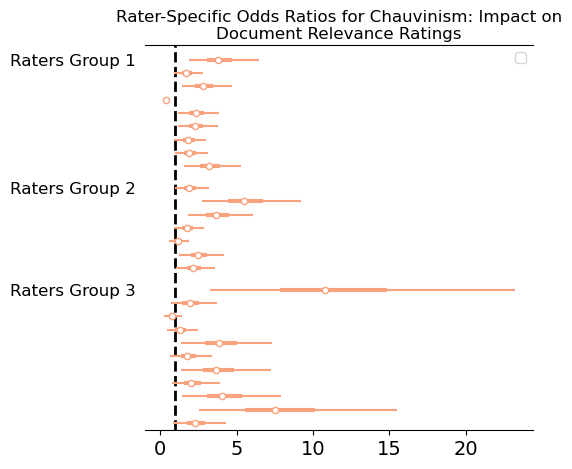

In [205]:
fig, ax = plt.subplots(figsize = (5,5))

import matplotlib.colors as mcolors  # Import the colors module from Matplotlib

# Convert RGBA tuples to hex color codes
color_list_hex = [mcolors.to_hex(color) for color in color_list]
ax.legend(['Odds ratio of 1'])
ax.axvline(1, color = 'black', ls = '--', lw = 2)

az.plot_forest(np.exp(trace_chauv_thurstonian_all.posterior[['g1chauvinism', 'g2chauvinism', 'chauvinism_hum']]),  colors = color_list_hex[0], combined = True, ax=ax)

custom_yticks =  [" " for i in range(10)] + ["Raters Group 3"] +   [" " for i in range(6)] + ["Raters Group 2"] +  [" " for i in range(8)]+ ["Raters Group 1"] 
ax.set_yticklabels(custom_yticks, fontsize=12)
ax.set_title("Rater-Specific Odds Ratios for Chauvinism: Impact on Document Relevance Ratings")
fig.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\chauv_OR.png', dpi=300, bbox_inches='tight')

plt.show()

In [232]:
es_raters.mean()

0.2546616666666667

In [227]:
az.extract_dataset(trace_chauv_thurstonian_all.posterior[['g1chauvinism', 'g2chauvinism', 'chauvinism_hum']])['g2chauvinism'].values.mean(axis = (0,2,3))

array([0.64343384, 1.70090451, 1.29821369, 0.55472308, 0.1419636 ,
       0.90664767, 0.76122058])

In [228]:
az.extract_dataset(trace_chauv_thurstonian_all.posterior[['g1chauvinism', 'g2chauvinism', 'chauvinism_hum']])['chauvinism_hum'].values.mean(axis = (0,2,3))

array([ 2.38352038,  0.65357776, -0.29644162,  0.24655957,  1.34679923,
        0.56314447,  1.30191724,  0.71721027,  1.39630433,  2.01763199,
        0.81773766])

In [230]:
np.exp(2.38352038)
# np.exp(-0.92804621)

10.843007259498876

In [33]:
es_chauv = categorical_es(binary_chauv)
es_chauv_onoff = get_effect_size(np.array(trials_chauv), np.array(trials_nochauv))

In [16]:
chauv_results = {'chauv_trials': binary_chauv,'trials_chauv':trials_chauv, 'trials_nochauv':trials_nochauv}

# Open a file to save the dictionary (in write-binary mode)
with open(r"C:\Users\conix\Documents\IIH_localtraces\chauvinism_ppc.pkl", 'wb') as file:
    # Use pickle.dump to serialize the dictionary and save it to the file
    pickle.dump(chauv_results, file)

In [11]:
with open(r"C:\Users\conix\Documents\IIH_localtraces\chauvinism_ppc.pkl", 'rb') as file:
    # Use pickle.load to deserialize the dictionary
    chauv_results = pickle.load(file)

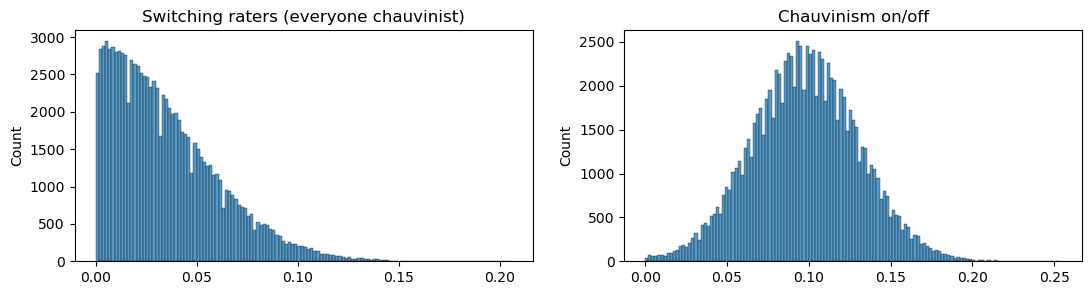

In [143]:
# Assuming content_ranks is a dictionary with the data

fig, ax = plt.subplots(ncols = 2, figsize = (13,3))
es_chauv_binary = categorical_es(binary_chauv)
es_chauv_onoff = get_effect_size(np.array(trials_chauv), np.array(trials_nochauv))
sns.histplot(es_chauv_binary, ax=ax[0])
sns.histplot(es_chauv_onoff, ax=ax[1])

ax[0].set_title('Switching raters (everyone chauvinist)')
ax[1].set_title('Chauvinism on/off')


plt.show()



# Strictness effect size

Given that it doesn't make conceptual sense to switch strictness on and off -- after all, all raters need to have some strictness level that is going to be individual given the difficulties of imagining the ideal committee -- we mostly focus on the effect of switching from one rater to another and are only planning to report that effect. 

We can use any of the models, as the strictness estimates should be the same, and strictness isn't connected to any of the other variables in the DAG.

In [17]:
trials_strictness = []
trials_nostrictness = []
binary_strictness = {"set1": [], "set2":[]}

for trial in tqdm(range(n_trials)):

    # get a set of documents to rate
    paper_intercepts = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['paper_intercepts'].values), n_papers).reshape(n_sets, K)
    fields = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['fields'].values), n_papers).reshape(n_sets, K)

    # rater sigma
    sigma = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['sigma'].values), (n_sets * new_J * K), replace = True)

    paper_values = paper_intercepts + fields

    
    
    # rater strictness
    strictness_sd1 = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['strictness_sd'].values), new_J, replace=True)
    strictness1 = np.random.normal(0,strictness_sd)

    strictness_sd2 = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['strictness_sd'].values), new_J, replace=True)
    strictness2 = np.random.normal(0,strictness_sd)
    
    
    # compare with and without strictness
    latent = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)) , sigma.reshape((n_sets,new_J, K)))
    p_strictness = expit(latent + strictness1.reshape(1, new_J, 1))
    p_no_strictness = expit(latent)

    trial_strictness1 = np.random.binomial(1,p_strictness)
    trials_strictness.append(trial_strictness1)
    trials_nostrictness.append(np.random.binomial(1,p_no_strictness))

    # switch from one set of raters to another, keeping other things equal

    p_strictness2 = expit(latent + strictness2.reshape(1, new_J, 1))
    binary_strictness["set1"].append(trial_strictness1)
    trial_strictness2 = np.random.binomial(1,p_strictness2)
    binary_strictness["set2"].append(trial_strictness2)



100%|██████████| 100000/100000 [01:15<00:00, 1317.37it/s]


In [34]:
es_strictness = categorical_es(binary_strictness)
es_strictness_onoff = get_effect_size(np.array(trials_strictness), np.array(trials_nostrictness))

In [18]:
strictness_results = {'strictness_trials': binary_strictness,'trials_strictness':trials_strictness, 'trials_nostrictness':trials_nostrictness}


# Open a file to save the dictionary (in write-binary mode)
with open(r"C:\Users\conix\Documents\IIH_localtraces\strictness_ppc.pkl", 'wb') as file:
    # Use pickle.dump to serialize the dictionary and save it to the file
    pickle.dump(strictness_results, file)

In [28]:

fig, ax = plt.subplots(ncols = 2, figsize = (13,3))
es_strictness_binary = categorical_es(binary_strictness)
es_strictness_onoff = get_effect_size(np.array(trials_strictness), np.array(trials_nostrictness))
sns.histplot(es_strictness_binary, ax=ax[0])
sns.histplot(es_strictness_onoff, ax=ax[1])

ax[0].set_title('Switching raters (everyone has strictness)')
ax[1].set_title('Strictness on/off')


plt.show()


# Switch between raters

Run the same experiment twice, only changing the rater. We do this many times, and record the differences in proportions of relevant documents between the two runs of the otherwise identical experiment.

In [19]:
trace_chauv_thurstonian_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\\trace_chauvinism_thurstonian_all_FINAL.nc")


In [20]:
rater1 = []
rater2 = []
n_papers = 150
n_sets = 30
K = 5

for trial in tqdm(range(n_trials)):

    # get the strictness for two random raters

    strictness_sd = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['strictness_sd'].values), (2), replace=True)
    strictness = np.random.normal(0,strictness_sd)

    # get the chauvinism for two raters

    chauvinism = np.random.normal(np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_mean'].values), 2, replace = True ),
                                 np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_sd'].values), 2, replace = True ))
    
    # get it in the shape of (sets, raters, K) for sampling. This just repeats the chauvinism values


    # get the rater field for the different raters
    # Should this be: randomly switch field? 
    rater_fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['rater_field'].values), 2)
    


    # now get a sample of papers (divided in sets of 5) to rate
    paper_intercepts = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['paper_intercepts'].values), n_papers).reshape(n_sets, K)
    fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['fields'].values), n_papers).reshape(n_sets, K)
    sigma = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['sigma'].values), 1, replace = True)


    
    
    
    paper_values = paper_intercepts + fields
    

    latent1 = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,1,1)) + rater_fields[0] + chauvinism[0] , sigma)
    latent2 = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,1,1)) + rater_fields[1] + chauvinism[1] , sigma)
    
    p1 = expit(latent1 + strictness[0])
    p2 = expit(latent2 + strictness[1])
    rater1.append(np.random.binomial(1,p1))
    rater2.append(np.random.binomial(1,p2))


100%|██████████| 100000/100000 [00:54<00:00, 1834.18it/s]


In [21]:
es_raters = abs(np.array(rater1).mean(axis = (1,2,3)) - np.array(rater2).mean(axis = (1,2,3)))


# Open a file to save the dictionary (in write-binary mode)
with open(r"C:\Users\conix\Documents\IIH_localtraces\raters_ppc.pkl", 'wb') as file:
    # Use pickle.dump to serialize the dictionary and save it to the file
    pickle.dump(es_raters, file)

In [5]:
with open(r"C:\Users\conix\Documents\IIH_localtraces\raters_ppc.pkl", 'rb') as file:
    # Use pickle.load to deserialize the dictionary
    es_raters = pickle.load(file)

In [ ]:
es_raters = abs(np.array(rater1).mean(axis = (1,2,3)) - np.array(rater2).mean(axis = (1,2,3)))
sns.histplot(es_raters, bins = 'doane')
plt.axvline(np.mean(es_raters))
plt.show()
print(np.mean(es_raters))

In [ ]:
az.plot_posterior(es_raters, point_estimate = 'median')

# Switch between papers

In [22]:
papers1 = []
papers2 = []

n_papers = 1
n_sets = 1
K = 1
J = 22
for trial in tqdm(range(n_trials)):

    # get the strictness for a random rater

    strictness_sd = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['strictness_sd'].values), (J), replace=True)
    strictness = np.random.normal(0,strictness_sd, J)

    # get the chauvinism for a random rater

    chauvinism = np.random.normal(np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_mean'].values),J, replace = True ),
                                 np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_sd'].values), J, replace = True ))
    

    # get the rater field for a rater
    rater_fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['rater_field'].values), J)
    


    # now get two samples of papers (divided in sets of 5) to rate
    paper_intercepts = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['paper_intercepts'].values), 2*n_papers).reshape(2,n_sets, K)
    fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['fields'].values), 2*n_papers).reshape(2,n_sets, K)
    sigma = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['sigma'].values), 1, replace = True)


    
    
    
    paper_values = paper_intercepts + fields

    

    latent1 = np.random.normal(np.tile(paper_values[0,:,:][:,np.newaxis,:],(1,J,1)) + rater_fields + chauvinism , sigma)
    latent2 = np.random.normal(np.tile(paper_values[1,:,:][:,np.newaxis,:],(1,J,1)) + rater_fields + chauvinism , sigma)
    
    p1 = expit(latent1 + strictness)
    p2 = expit(latent2 + strictness)
    papers1.append(np.random.binomial(1,p1))
    papers2.append(np.random.binomial(1,p2))


100%|██████████| 100000/100000 [00:56<00:00, 1765.63it/s]


In [23]:
es_papers = abs(np.array(papers1).mean(axis = (1,2,3)) - np.array(papers2).mean(axis = (1,2,3)))


with open(r"C:\Users\conix\Documents\IIH_localtraces\documents_ppc.pkl", 'wb') as file:
    # Use pickle.dump to serialize the dictionary and save it to the file
    pickle.dump(es_papers, file)

In [6]:
with open(r"C:\Users\conix\Documents\IIH_localtraces\documents_ppc.pkl", 'rb') as file:
    # Use pickle.load to deserialize the dictionary
    es_papers = pickle.load(file)

In [ ]:
es_papers = abs(np.array(papers1).mean(axis = (1,2,3)) - np.array(papers2).mean(axis = (1,2,3)))
sns.histplot(es_papers, bins = 'doane')
print(es_papers.mean())
plt.show()

In [ ]:
az.plot_posterior(es_papers, hdi_prob = 0.94, point_estimate = 'median')

In [42]:
len(es_field)

1000000

In [ ]:
# make all effect sizes the same shape

effect_sizes = [es_papers, es_raters,es_field, es_content] #, es_strictness, es_strictness_onoff,es_chauv, es_chauv_onoff, 
effect_sizes = [list(lst) for lst in effect_sizes]  # Convert all elements to lists

names = ['es_papers', 'es_raters','es_field', 'es_content'] #, 'es_strictness', 'strictness_onoff', 'es_chauvinism', 'chauvinism_onoff','es_field', 'es_content'
# Step 1: Find the length of the shortest list
min_size = min(len(lst) for lst in effect_sizes)

# Step 2 and 3: Resize all lists to the length of the shortest list

# Step 2: Create the dictionary with names as keys and resized lists as values
es_dict = {
    name: (random.sample(lst, min_size) if len(lst) > min_size else lst)
    for name, lst in zip(names, effect_sizes)
}

df_es = pd.DataFrame(es_dict)


In [46]:
with open(r"C:\Users\conix\Documents\IIH_localtraces\df_ppc.pkl", 'wb') as file:
    # Use pickle.dump to serialize the dictionary and save it to the file
    pickle.dump(df_es, file)

In [4]:
with open(r"C:\Users\conix\Documents\IIH_localtraces\df_ppc.pkl", 'rb') as file:
    # Use pickle.load to deserialize the dictionary
    df_es = pickle.load(file)

In [5]:
df_es.head()

,es_papers,es_raters,es_strictness,strictness_onoff,es_chauvinism,chauvinism_onoff,es_field,es_content
0,0.361570,0.420000,0.1184,0.0180,0.1400,0.0304,0.0568,0.0112
1,0.357438,0.520000,0.2600,0.1324,0.0136,0.0644,0.1060,0.0676
2,0.278926,0.526667,0.0588,0.0904,0.0568,0.1136,0.1664,0.0756
3,0.008264,0.100000,0.0636,0.0108,0.0292,0.1048,0.1644,0.0556
4,0.076446,0.073333,0.1016,0.0888,0.1048,0.1536,0.1940,0.0760


In [3]:
# df_es = pd.DataFrame(es_dict)
# print(len(df_es))
# df_es.head()

NameError: name 'es_dict' is not defined

# Make figures for paper

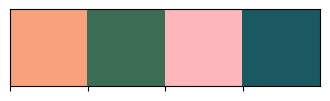

In [10]:
from cmcrameri import cm


# Step 1: Choose a specific color palette from cmcrameri
palette_name = cm.batlow  # Replace 'batlow' with the name of the palette you want

# Step 2: Generate a list of colors by sampling the ListedColormap
n_colors = 10  # Number of colors you want

# Use numpy.linspace to sample the colormap
color_list = [palette_name(i) for i in np.linspace(0, 1, n_colors)]

# Step 3: Use the palette or print the list of colors
color_list = [color_list[7],color_list[3], color_list[8], color_list[2]]

# Optionally, you can visualize the palette
sns.palplot(color_list)
plt.show()


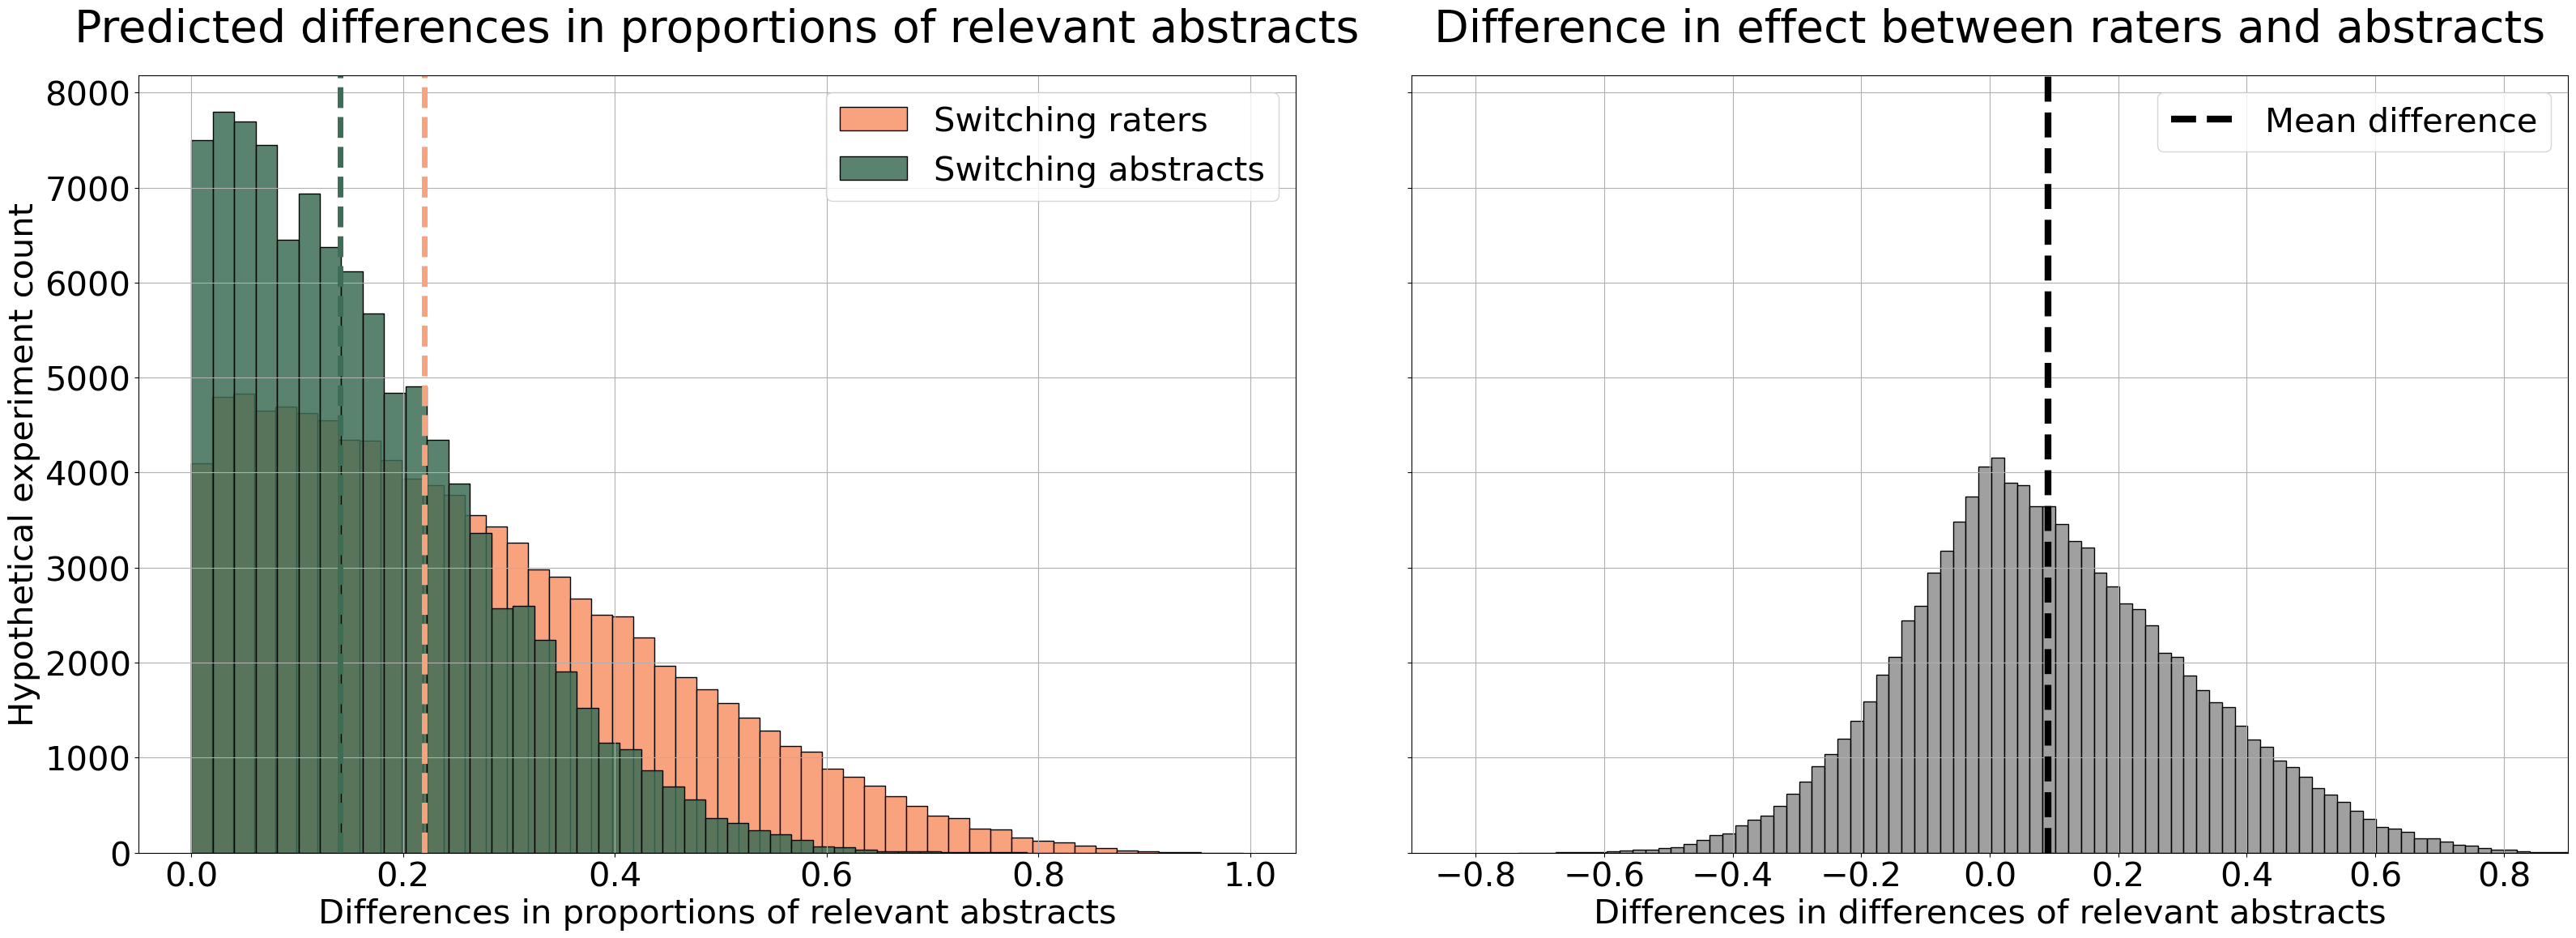

In [10]:
from cmcrameri import cm

title_fs = 40
label_fs = 30
binning_method = 'fd'
bin_width =0.02

plt.style.use('default')

fig, ax = plt.subplots(ncols = 2, figsize = (40,12), sharey=True)

sns.histplot(df_es.es_raters,  color= color_list[0], ax=ax[0], alpha =1,  binwidth = bin_width, bins = binning_method)
sns.histplot(df_es.es_papers, color = color_list[1], ax=ax[0], alpha = 0.85,  binwidth = bin_width,  bins = binning_method )
ax[0].legend(['Switching raters', 'Switching abstracts'],fontsize = label_fs)

sns.histplot(df_es.es_raters-df_es.es_papers,  color = 'grey', ax=ax[1],  binwidth = bin_width,  bins = binning_method)
ax[1].axvline((df_es.es_raters-df_es.es_papers).mean(), color = 'black', ls = '--', lw = 6)
ax[1].legend(['Mean difference'], fontsize = label_fs)

ax[0].set_title('Predicted differences in proportions of relevant abstracts', fontsize = title_fs, pad = 30)
ax[1].set_title('Difference in effect between raters and abstracts', fontsize = title_fs, pad = 30)

ax[0].set_ylabel('Hypothetical experiment count', fontsize = label_fs)
ax[0].set_xlabel('Differences in proportions of relevant abstracts', fontsize = label_fs)
ax[1].set_xlabel('Differences in differences of relevant abstracts', fontsize = label_fs)
ax[1].set_xlim([-0.9,0.9])
ax[0].tick_params(axis='both', which='major', labelsize=label_fs)
ax[1].tick_params(axis='both', which='major', labelsize=label_fs)
ax[0].axvline(np.median(es_papers), ls = '--', lw = 5, color = color_list[1], alpha = 1)
ax[0].axvline(np.median(es_raters), ls = '--', lw = 5, color = color_list[0], alpha = 1)

ax[0].grid(True, which = 'major')
ax[1].grid(True, which = 'major')
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.3)
fig.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\docrater_effectsizes.png', dpi=300, bbox_inches='tight')

plt.show()

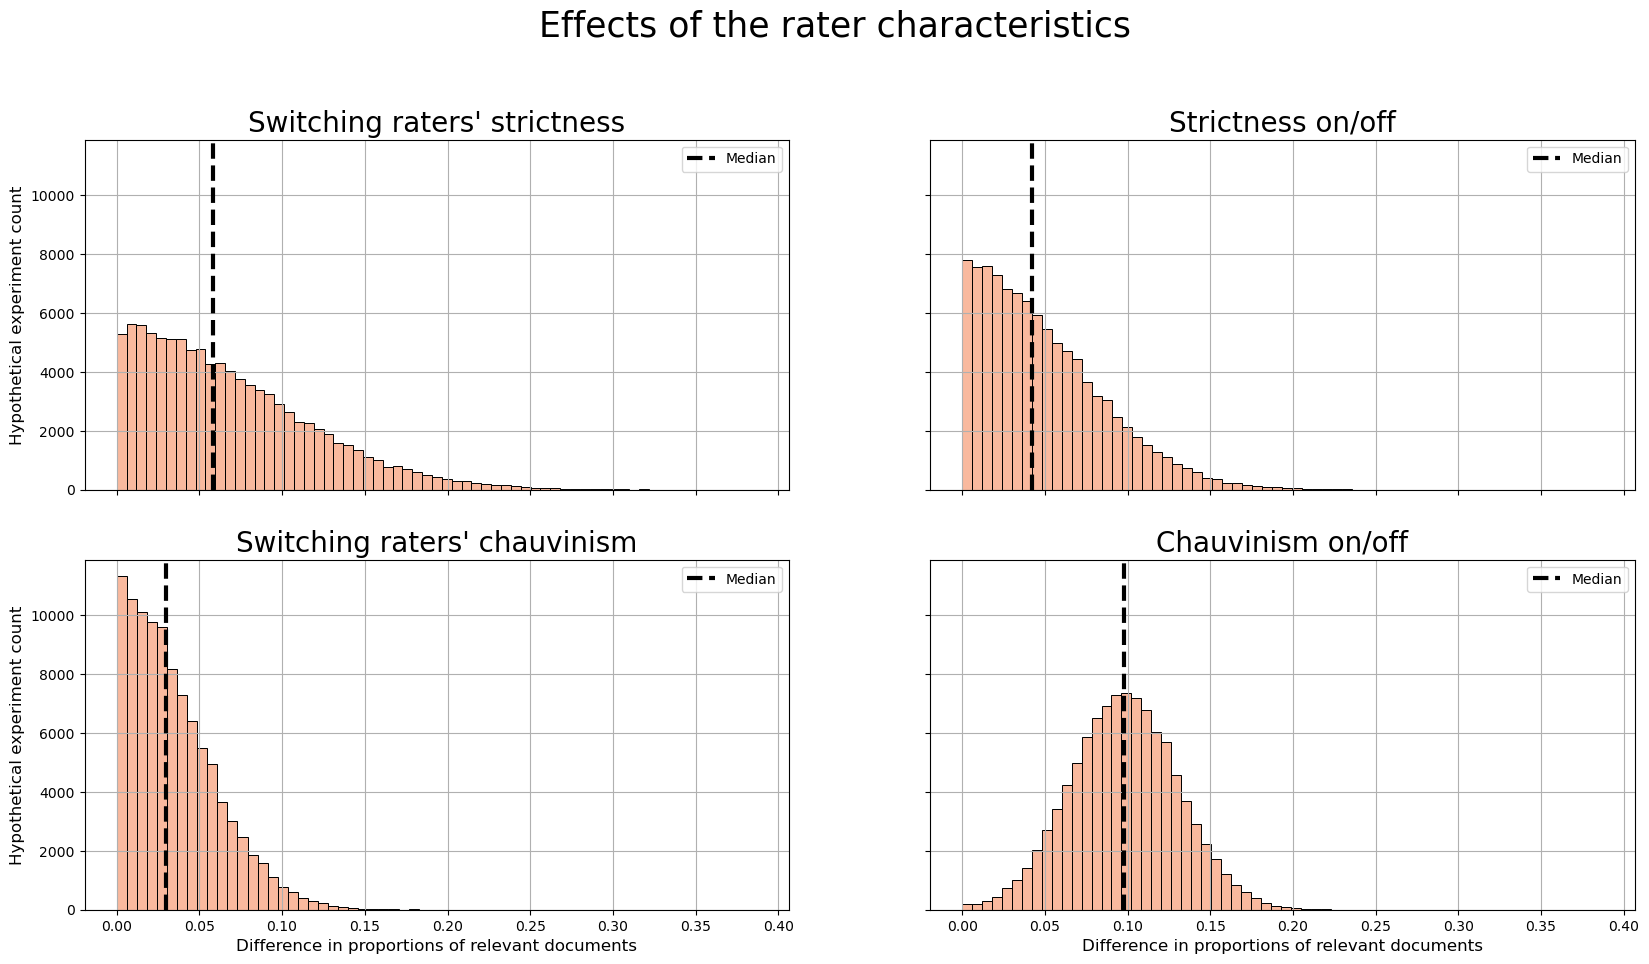

In [172]:
# Rater parameters: effect sizes

title_fs = 20
label_fs = 12
binning_method = 'fd'
bin_width =0.006

fig, ax = plt.subplots(2,2, figsize = (20,10), sharey = True, sharex = True)

sns.histplot(df_es.es_strictness, ax=ax[0,0],color = color_list[0],  binwidth = bin_width, bins = binning_method)
sns.histplot(df_es.strictness_onoff, ax=ax[0,1],color = color_list[0],  binwidth = bin_width, bins = binning_method)

for i in ax.flatten():
    i.grid(True)

ax[0,0].set_title("Switching raters' strictness", fontsize = title_fs)
ax[0,1].set_title('Strictness on/off', fontsize = title_fs)



sns.histplot(df_es.es_chauvinism, ax=ax[1,0], color = color_list[0],  binwidth = bin_width, bins = binning_method)
sns.histplot(df_es.chauvinism_onoff, ax=ax[1,1],color = color_list[0],  binwidth = bin_width, bins = binning_method)

ax[1,0].set_title("Switching raters' chauvinism", fontsize = title_fs)
ax[1,1].set_title('Chauvinism on/off', fontsize = title_fs)

ax[0,0].set_ylabel('Hypothetical experiment count', fontsize = label_fs)
ax[1,0].set_ylabel('Hypothetical experiment count',fontsize = label_fs)

ax[1,0].set_xlabel('Difference in proportions of relevant documents',fontsize = label_fs)
ax[1,1].set_xlabel('Difference in proportions of relevant documents',fontsize = label_fs)


ax[0,0].axvline(df_es.es_strictness.median(), color = 'black', lw = 3, ls = '--')
ax[0,1].axvline(df_es.strictness_onoff.median(), color = 'black', lw = 3, ls = '--')
ax[1,0].axvline(df_es.es_chauvinism.median(), color = 'black', lw = 3, ls = '--')
ax[1,1].axvline(df_es.chauvinism_onoff.median(), color = 'black', lw = 3, ls = '--')
for i in ax.flatten():
    i.legend(['Median'])


plt.suptitle('Effects of rater characteristics', fontsize = 25, y = 1.01)
fig.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\rater_effectsizes.png', dpi=300, bbox_inches='tight')

plt.show()


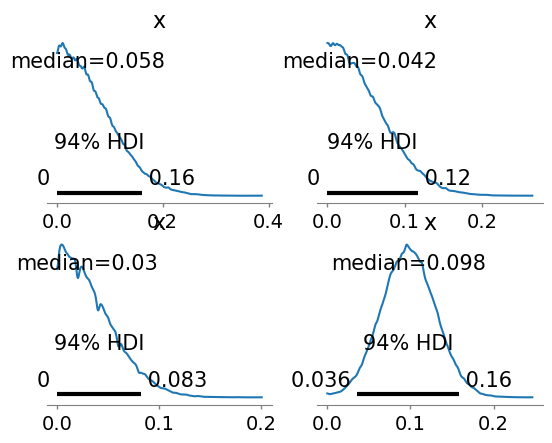

In [132]:
fig, axs = plt.subplots(2,2)

for ax, i in zip(axs.flat, [df_es.es_strictness, df_es.strictness_onoff, df_es.es_chauvinism, df_es.chauvinism_onoff]):
    az.plot_posterior(i.values, point_estimate = 'median', ax=ax)
    

## separate ridgeplots

In [515]:
# plot the main figure also as a ridgeplot given that everything is overlapping here

# from matplotlib.ticker import FixedLocator

# # Ignore the specific UserWarnings related to tight_layout
# warnings.filterwarnings('ignore', category=UserWarning)
# # Convert dictionary to a long-form DataFrame for seaborn
# dfx = pd.DataFrame([np.array(field_trials[i]).mean(axis = (1,2,3)) for i in fields_order], index = fields_order).T
# dfx = dfx.melt(var_name='Field', value_name='Effect Size')

# # Create the ridge plot
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# # colors 
# sns_palette = sns.color_palette("Greens", 5)

# # Create the data for the ridge plot
# g = sns.FacetGrid(dfx, row="Field", hue="Field", aspect=9, height=5, palette=sns_palette[::-1])





# # Map the density plots to each facet
# g.map(sns.kdeplot, "Effect Size", clip_on=False, shade=True, alpha=1, lw=2.5, bw_adjust=0.5)
# g.map(sns.kdeplot, "Effect Size", clip_on=False, color="w", lw=2, bw_adjust=.5)

# # Define a function to add a line for each level
# def add_line(x, **kwargs):
#     plt.axhline(y=x.name, color='black', lw=2, clip_on=False)

# # Apply the function to each facet
# g.map(add_line, "Effect Size")

# # Set the subplots to overlap
# g.fig.subplots_adjust(hspace=-0.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set_xlabels('')
# # g.set_xlabels("Proportion of 1s", fontsize = 20)
# g.set_ylabels('')
# ytick_positions = [0, 1, 2,3,4]
# for ax, field in zip(g.axes.flat,fields_order):
#     ax.set_yticks([4])  # Each subplot has a single y-tick at position 0
#     ax.set_ylabel(field, fontsize = 60, rotation = 0)
#     ax.tick_params(axis='x', labelsize=40)

# g.despine(bottom=True, left=True)
# # plt.suptitle("Proportions of 1s in posterior predictive sampling from different fields", fontsize = 25)
# g.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\field_effectsizes_subplot.png', dpi=150, bbox_inches='tight')

# # Show the plot
# plt.show()


In [516]:
# content_params2 = content_trials.keys()

# # Convert dictionary to a long-form DataFrame for seaborn
# dfx = pd.DataFrame([np.array(content_trials[i]).mean(axis = (1,2,3)) for i in content_params2 ], index = content_params2 ).T.stack().reset_index()
# dfx.columns = ['index','Code','value']

# # Create the ridge plot
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# # colors 
# sns_palette = sns.color_palette("Blues", 9)

# # Create the data for the ridge plot
# g = sns.FacetGrid(dfx, row="Code", hue="Code", aspect=13, height=6, palette=sns_palette[::-1])

# # Map the density plots to each facet
# g.map(sns.kdeplot, "value", clip_on=False, shade=True, alpha=1, lw=1.5, bw_adjust=0.5)
# g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)

# # Define a function to add a line for each level
# def add_line(x, **kwargs):
#     plt.axhline(y=x.name, color='black', lw=2, clip_on=False)

# # Apply the function to each facet
# g.map(add_line, "value")

# # Set the subplots to overlap
# g.fig.subplots_adjust(hspace=-0.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# # g.set_xlabels("Proportion of 1s", fontsize = 25)
# g.set_ylabels('')
# g.set_xlabels('')

# ytick_positions = [0, 1, 2,3,4,5,6,7,8]
# for ax, field in zip(g.axes.flat,content_params2 ):
#     ax.set_yticks([7])  # Each subplot has a single y-tick at position 0
#     # ax.set_ylabel(field, fontsize = 100, rotation = 0)
#     ax.tick_params(axis='x', labelsize=50)

# g.despine(bottom=True, left=True)
# # plt.suptitle("Proportions of 1s in posterior predictive sampling from different content codes", fontsize = 25)


# # plt.suptitle("Proportions of 1s in posterior predictive sampling from different fields", fontsize = 25)
# g.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\content_effectsizes_subplot.png', dpi=72, bbox_inches='tight')

# # Show the plot
# plt.show()

## rater and document characteristics

C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\p

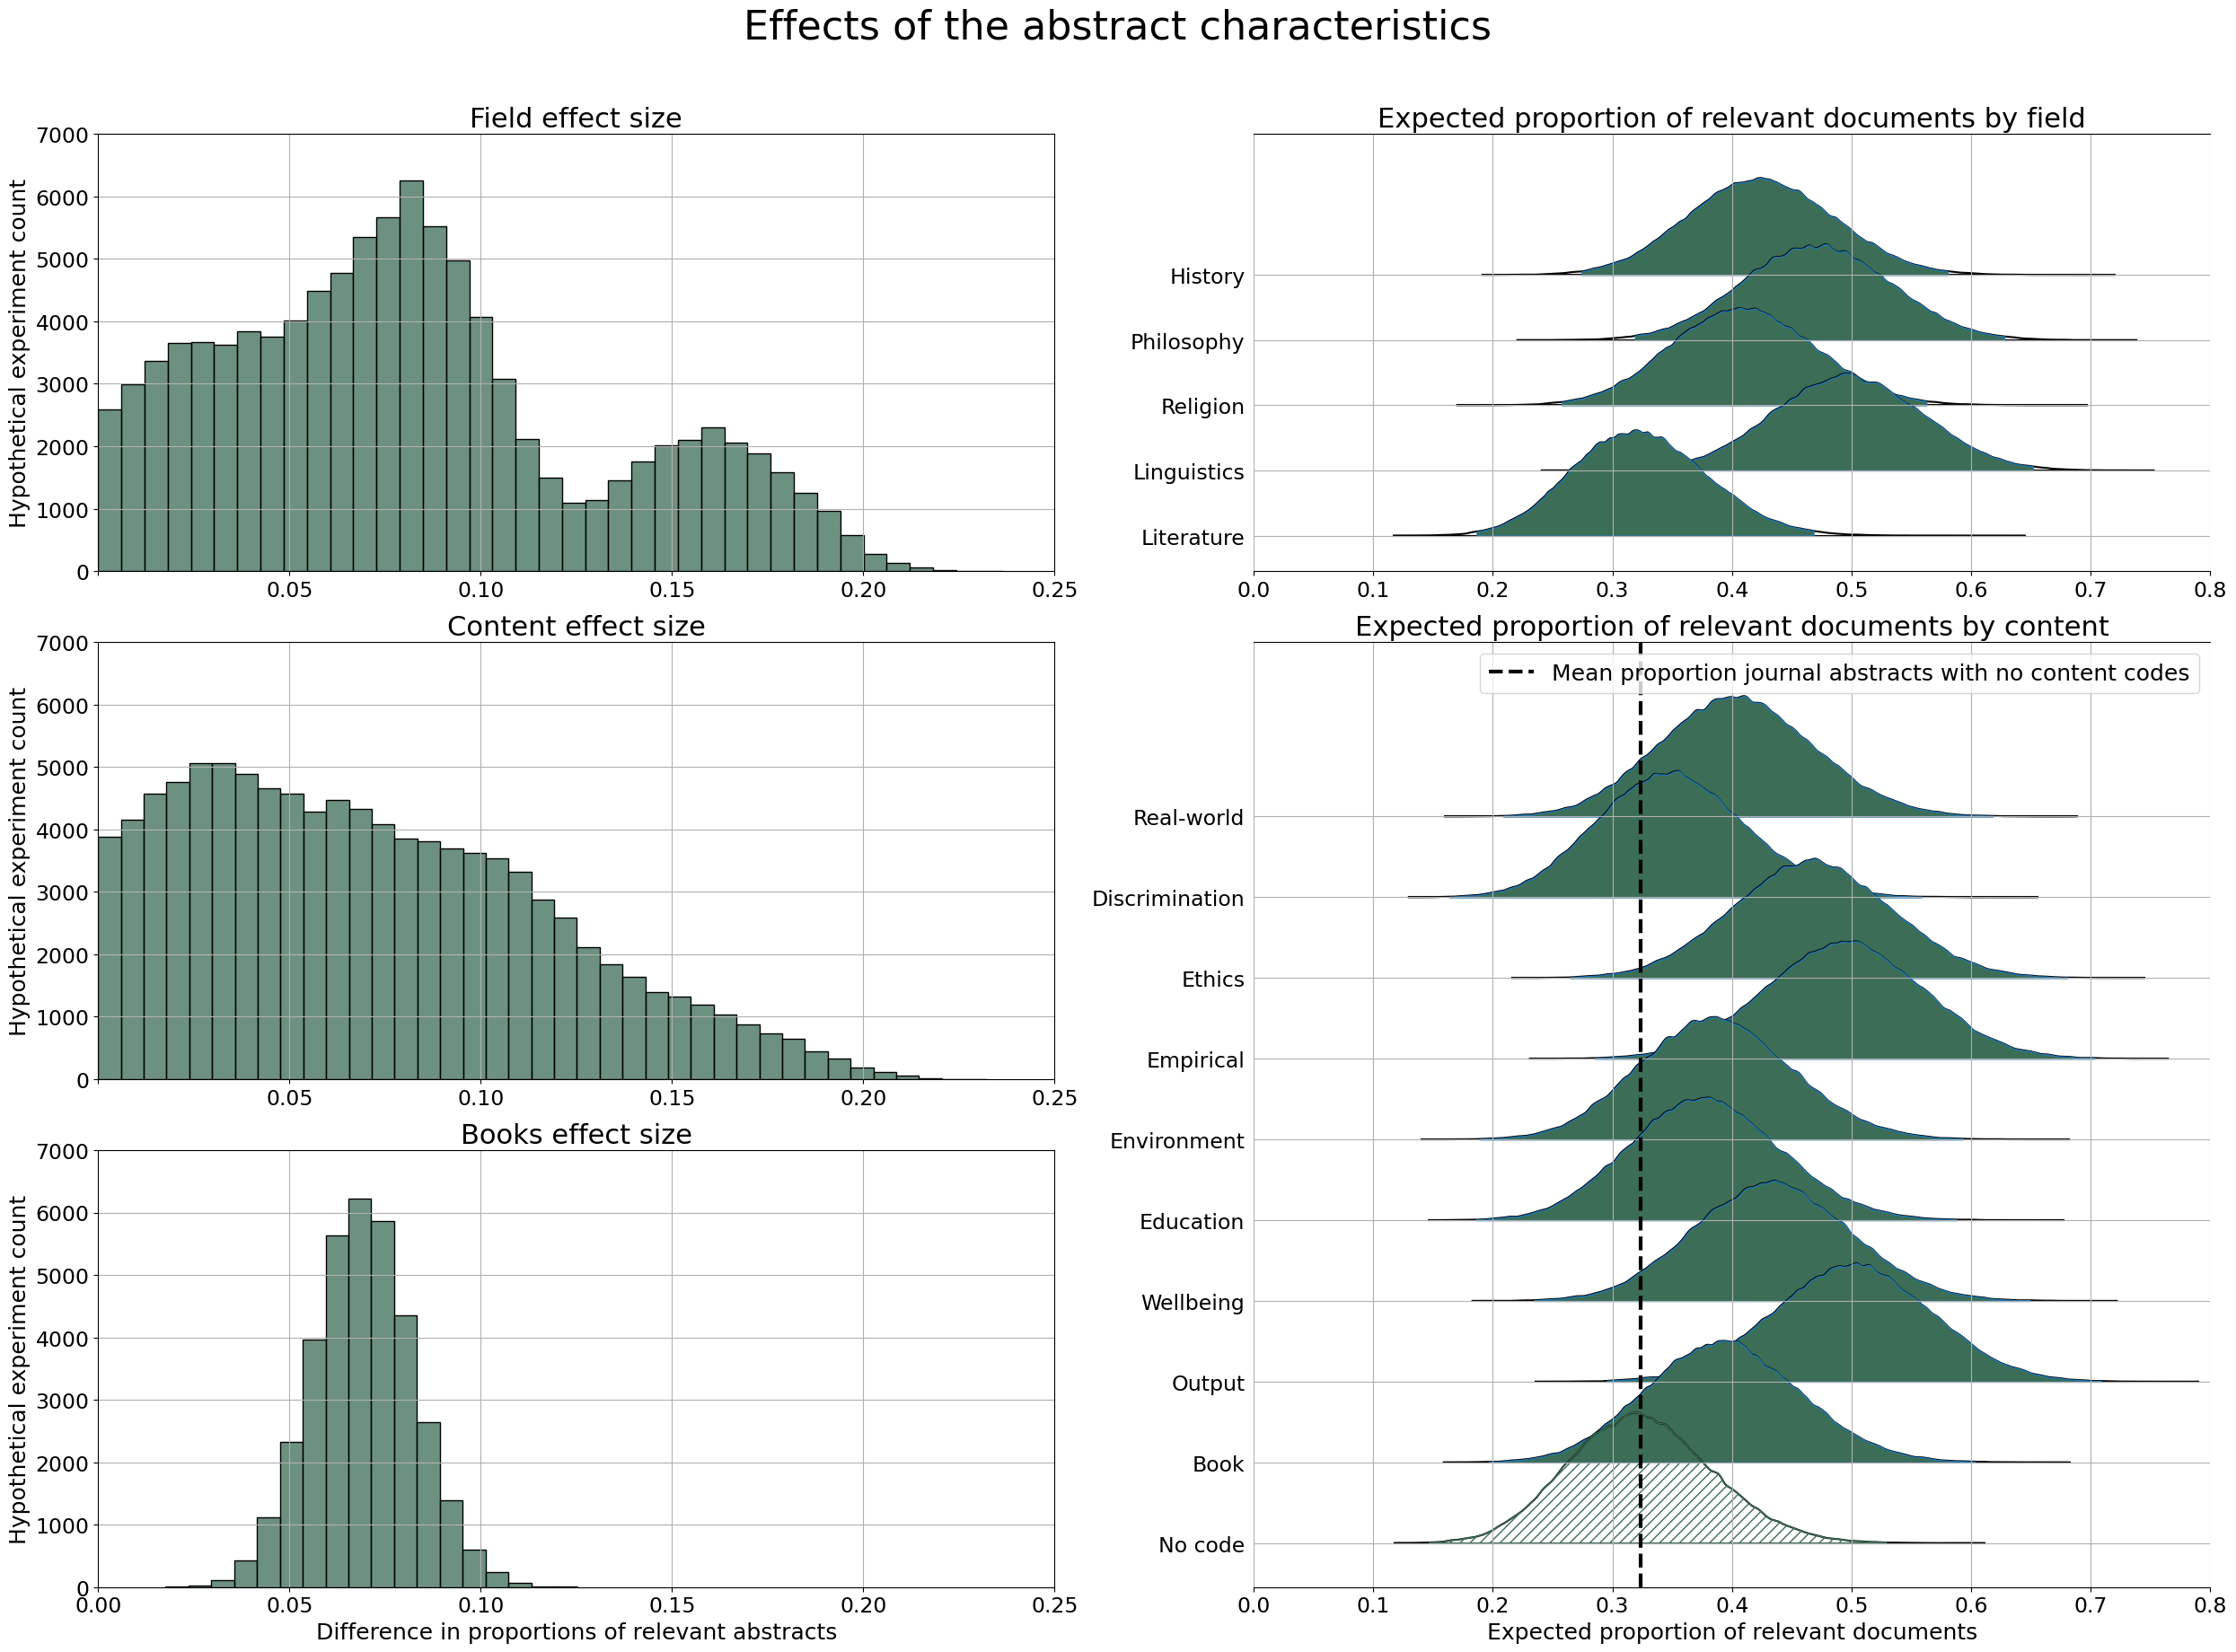

In [17]:
from matplotlib.gridspec import GridSpec
content_trials = {key: content_trials[key] for key in ['fiction', 'intolerance', 'ethics', 'empirical', 'environment', 'education', 'wellbeing', 'deliverable',  'Book','No code']}

# Define font size variables
title_fs = 22
ylabel_fs = 18
label_fs = 28
tick_fs = 17
suptitle_fs = 32
binning_method = 'fd'
bin_width = 0.006

# Create the figure and GridSpec object
fig = plt.figure(figsize=(25, 18))
gs = GridSpec(6, 6, figure=fig)

# Define axes using GridSpec
ax1 = fig.add_subplot(gs[:2, :3])  # First plot on the top left
ax2 = fig.add_subplot(gs[:2, 3:])  # First plot on the top right
ax3 = fig.add_subplot(gs[2:4, :3])  # Second plot on the middle left
ax4 = fig.add_subplot(gs[2:, 3:])  # Second plot on the middle right
ax5 = fig.add_subplot(gs[4:, :3])  # Third plot on the bottom left

# Set limits for the axes
for i in [ax1, ax3, ax5]:
    i.set_xlim(0, 0.25)
    i.set_ylim(0, 7000)

for i in [ax2, ax4]:
    i.set_xlim(0, 0.8)

# Plot 1: es fields
sns.histplot(df_es.es_field, color=color_list[1], ax=ax1, binwidth=bin_width, bins=binning_method)
ax1.set_title('Field effect size', fontsize=title_fs)
ax1.set_ylabel('Hypothetical experiment count', fontsize=ylabel_fs)
ax1.tick_params(axis='both', which='major', labelsize=tick_fs)
ax1.set_xlabel('')

# Remove redundant ticks on the x-axis for plot 1
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}' if x != 0 else ''))

# Plot 2: ridgeplot fields
stacked_array = np.array([np.array(field_trials[i]).mean(axis=(1, 2, 3)) for i in fields_order])
shape1, shape2 = stacked_array.shape
stacked_array = stacked_array.T.reshape((1, shape2, shape1))

datadict = {"fields": stacked_array}
coords = {"field_names": fields_order}
dims = {"fields": ["field_names"]}
dataset = az.convert_to_inference_data(datadict, coords=coords, dims=dims)

az.plot_forest(dataset, kind='ridgeplot', ridgeplot_truncate=False, hdi_prob=0.99,
               ridgeplot_alpha=1, ridgeplot_overlap=4, ax=ax2)

ax2.set_yticklabels(list(field_trials.keys())[::-1], fontsize=tick_fs)
ax2.set_title('Expected proportion of relevant documents by field', fontsize=title_fs)
ax2.tick_params(axis='both', which='major', labelsize=tick_fs)

for i, poly in enumerate(ax2.collections):
    poly.set_facecolor(color_list[1])

# Plot 3: es content
sns.histplot(df_es.es_content, ax=ax3, color=color_list[1], binwidth=bin_width, bins=binning_method)
ax3.set_ylabel('Hypothetical experiment count', fontsize=ylabel_fs)
ax3.set_xlabel('', fontsize=ylabel_fs)
ax3.set_title('Content effect size', fontsize=title_fs)

ax3.tick_params(axis='both', which='major', labelsize=tick_fs)

# Remove redundant ticks on the x-axis for plot 3
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}' if x != 0 else ''))

# Plot 4: ridgeplot content
stacked_array = np.array([np.array(content_trials[i]).mean(axis=(1, 2, 3)) for i in content_trials.keys()])
shape1, shape2 = stacked_array.shape
stacked_array = stacked_array.T.reshape((1, shape2, shape1))

datadict = {"content": stacked_array}
coords = {"content_names": list(content_trials.keys())}
dims = {"content": ["content_names"]}
dataset = az.convert_to_inference_data(datadict, coords=coords, dims=dims)
ax4.axvline(np.array(content_trials['No code']).mean(), ls = '--', lw = 3, color = 'black')

az.plot_forest(dataset, kind='ridgeplot', ridgeplot_truncate=False, hdi_prob=0.999,
               ridgeplot_alpha=1, ridgeplot_overlap=4, ax=ax4)
labels_content = ['Real-world', 'Discrimination','Ethics','Empirical','Environment','Education','Wellbeing','Output','Book','No code']#list(content_trials.keys())[::-1]
labels_content.reverse()
ax4.set_yticklabels(labels_content, fontsize=tick_fs)
ax4.set_xlabel('Expected proportion of relevant documents', fontsize=ylabel_fs)
ax4.set_title('Expected proportion of relevant documents by content', fontsize=title_fs)
ax4.tick_params(axis='both', which='major', labelsize=tick_fs)

for i, poly in enumerate(ax4.collections):
    if i == 0:
        poly.set_facecolor('none')  # Set face color to none
        poly.set_edgecolor(color_list[1])  # Set the edge color for better visibility
        poly.set_hatch('///')  # Set the hatch pattern (you can adjust the pattern here)
    else:
        poly.set_facecolor([color_list[1]])

ax4.legend(['Mean proportion journal abstracts with no content codes'], fontsize = ylabel_fs)
# Plot 5: additional histogram (simulated random data)
book_es = get_effect_size(np.array(content_trials['Book']), np.array(content_trials['No code']))
sns.histplot(np.random.choice(book_es, 35000, replace=False), ax=ax5, color=color_list[1], binwidth=bin_width, bins=binning_method)
ax5.set_ylabel('Hypothetical experiment count', fontsize=ylabel_fs)
ax5.set_xlabel('Difference in proportions of relevant abstracts', fontsize=ylabel_fs)
ax5.set_title('Books effect size', fontsize=title_fs)

ax5.tick_params(axis='both', which='major', labelsize=tick_fs)

# Apply grid to all subplots
for i in [ax1, ax2, ax3, ax4, ax5]:
    i.grid(True)

# Set the overall title and layout adjustments
plt.suptitle('Effects of the abstract characteristics', fontsize=suptitle_fs, y=1.02)
fig.tight_layout()

# # Save the figure
fig.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\document_effectsizes.png', dpi=300, bbox_inches='tight')

# # Show the plot
plt.show()



In [ ]:
az.plot_posterior(df_es.es_field.values, point_estimate = 'median')

# QUESTION 1: Variation in raters' judgement of societal relevance

## Method 1.1: Absolute effect sizes

All three of these effect sizes will be reported.

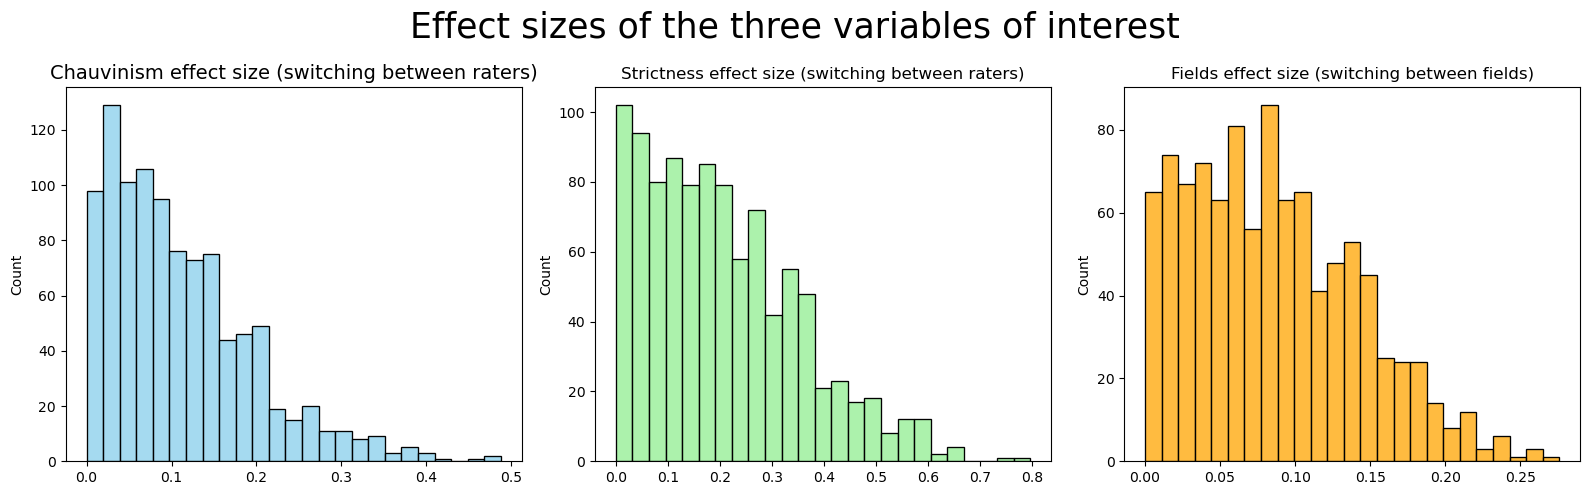

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16,5), sharey = False, sharex = False)

n_bins = int(n_trials/15)
ks = 1000
sns.histplot(random.choices(es_chauv, k = ks),bins = 25,ax = ax[0], color = colors[0])
sns.histplot(random.choices(es_strictness, k = ks),bins = 25, ax = ax[1],color = colors[1]) 
sns.histplot(es_fields,bins = 25,ax = ax[2],color = colors[2]) 


ax[0].set_title(f'Chauvinism effect size (switching between raters)', fontsize = 14)
ax[1].set_title(f'Strictness effect size (switching between raters)')
ax[2].set_title(f'Fields effect size (switching between fields)')

plt.suptitle('Effect sizes of the three variables of interest', fontsize = 25)

fig.tight_layout()

In [51]:
np.array(es_chauv).mean()

0.11131022222222223

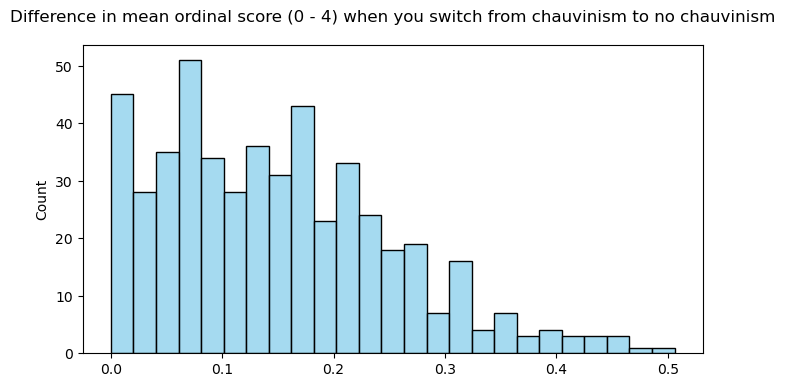

In [24]:
fig, ax = plt.subplots(figsize = (8,4))
sns.histplot(es_chauv_rank,bins = 25,color = colors[0],ax=ax)
ax.set_title('Difference in mean ordinal score (0 - 4) when you switch from chauvinism to no chauvinism', y = 1.05)
plt.show()

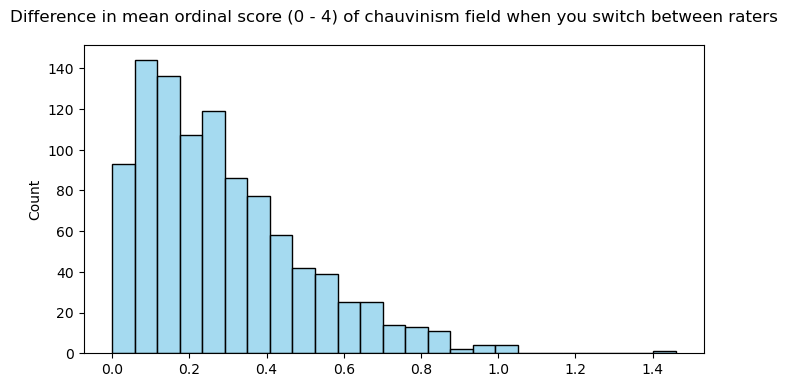

In [25]:
# for chauvinism, we can also plot the effect on rank scores of the field one is chauvinistic about

fig, ax = plt.subplots(figsize = (8,4))
sns.histplot(random.choices(es_chauv_rank2, k = ks),bins =25,color = colors[0],ax=ax)
ax.set_title('Difference in mean ordinal score (0 - 4) of chauvinism field when you switch between raters', y = 1.05)
plt.show()

## Method 1.2: Compare the effect sizes of chauvinism, strictness and field

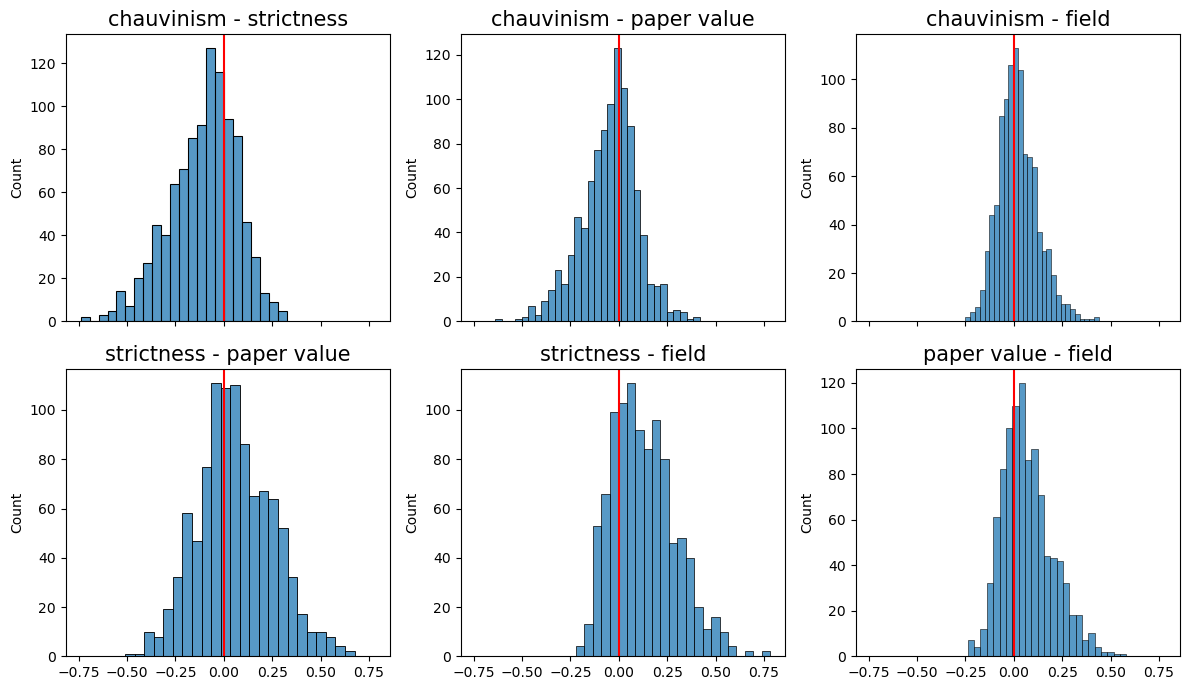

In [26]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12,7), sharey = False, sharex = True)

es_strictness_short = np.array(random.choices(es_strictness, k=ks))
es_chauv_short = np.array(random.choices(es_chauv, k=ks))
es_papervals_short = np.array(random.choices(es_papervals, k=ks))

dct = {'chauvinism':es_chauv_short,'strictness':es_strictness_short,'paper value':es_papervals_short,'field':es_fields}

for ax, i in zip(axs.flat, combinations(range(4),2)):
    
    sns.histplot(list(dct.values())[i[0]]- list(dct.values())[i[1]],ax = ax) #, bw_adjust = 2



    ax.set_title(f'{list(dct.keys())[i[0]]} - {list(dct.keys())[i[1]]}', fontsize = 15)
    ax.axvline(0, color = 'r')

fig.tight_layout()

## Turin conference figure

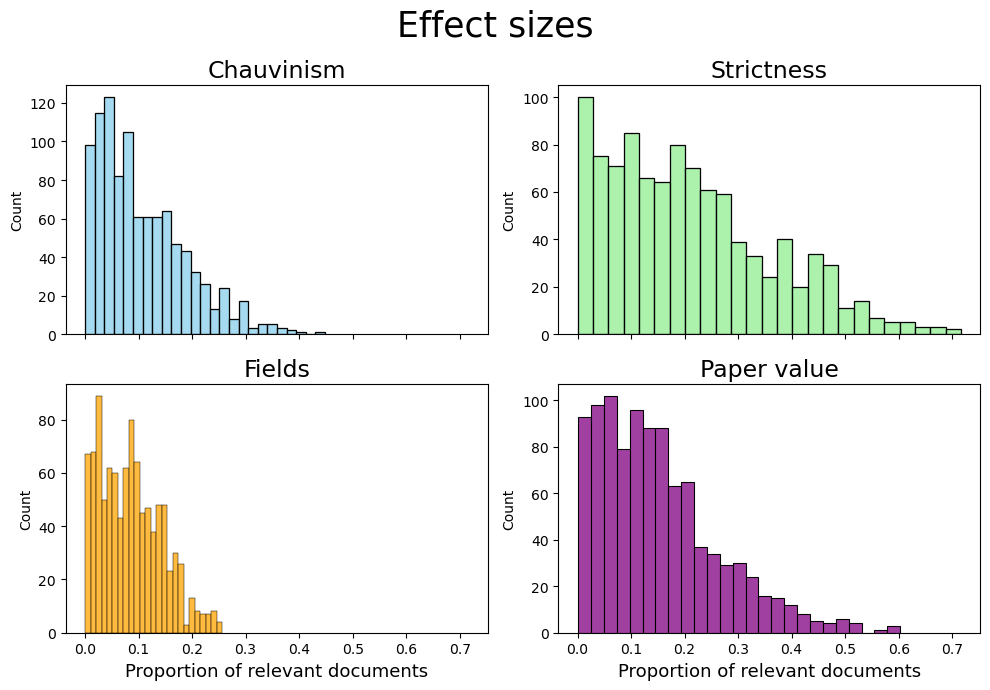

In [27]:
# Figure for conference paper in Turin

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7), sharey = False, sharex = True)

n_bins = int(n_trials/15)

sns.histplot(random.choices(es_chauv, k=ks),bins = 25,ax = ax[0,0], color = colors[0])
sns.histplot(random.choices(es_strictness, k=ks),bins = 25, ax = ax[0,1],color = colors[1]) 
sns.histplot(random.choices(es_fields, k=ks),bins = 25,ax = ax[1,0],color = colors[2]) 
sns.histplot(random.choices(es_papervals, k=ks), bins = 25, color = colors[3], ax=ax[1,1])


ax[0,0].set_title(f'Chauvinism', fontsize = 17)
ax[0,1].set_title(f'Strictness', fontsize = 17)
ax[1,0].set_title(f'Fields', fontsize = 17)
ax[1,1].set_title(f'Paper value', fontsize = 17)

ax[1,0].set_xlabel('Proportion of relevant documents', fontsize = 13)
ax[1,1].set_xlabel('Proportion of relevant documents', fontsize = 13)


plt.suptitle('Effect sizes', fontsize = 25)




fig.tight_layout()
# Save the figure
fig.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\turin_effectsizes.png')

# QUESTION 2: Differences between fields

We will at least report the top figure or ridgeplot, i.e. the one based on posterior predictive samples.

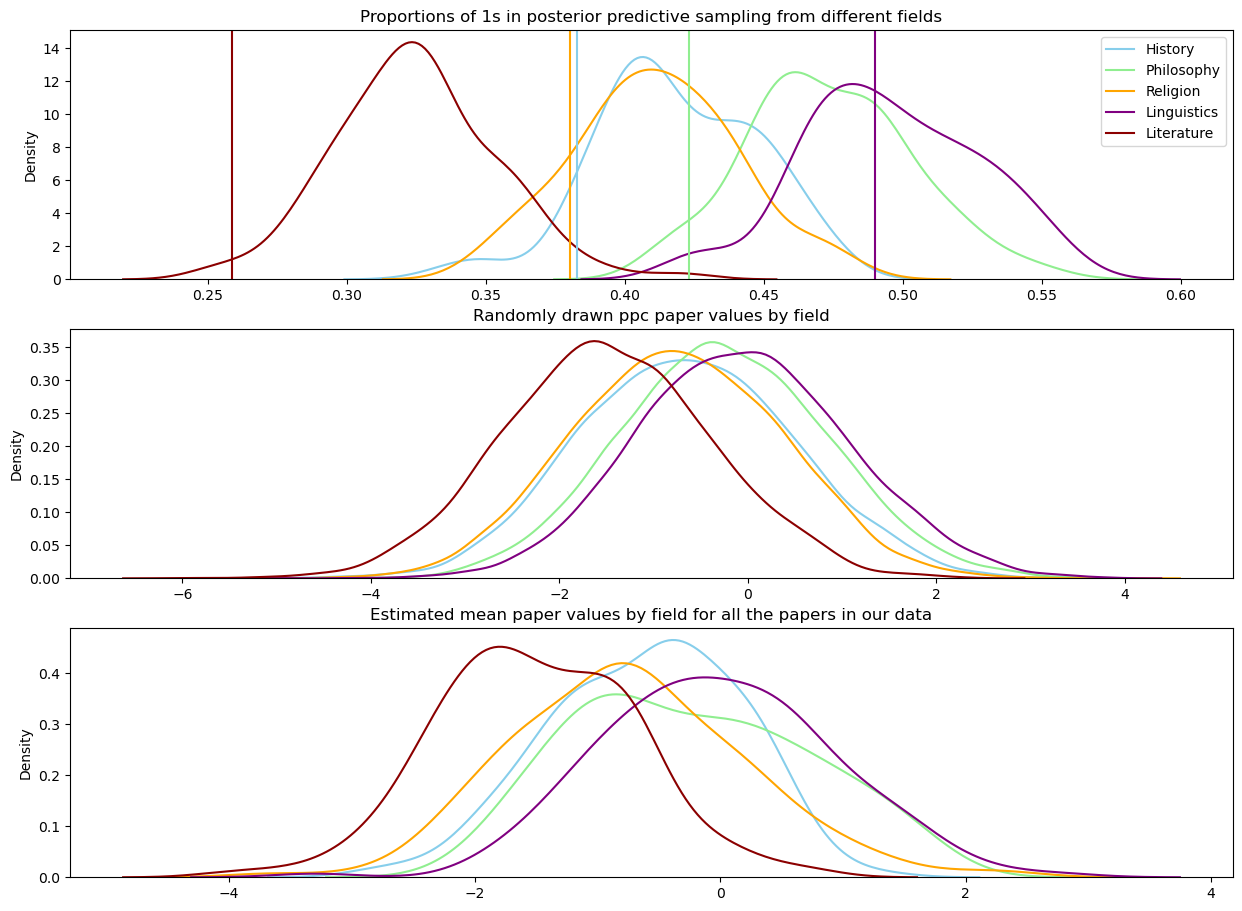

In [28]:
# plot the distribution of proportions of 1s for all fields

fig, ax = plt.subplots(nrows = 3, figsize = (15,11))


for i,field in enumerate(fields_order): 
    trial_means = np.array([trials[i].mean(axis = (0,1)) for i in range(n_trials)])
    f = sns.kdeplot(trial_means[:,i], color = colors[i], ax=ax[0])
    
    paper_vals = np.concatenate([est_papervals_fields[i] for i in range(n_trials)])
    f2 = sns.kdeplot(paper_vals[:,i], color = colors[i], ax=ax[1])
ax[0].legend(fields_order)

# indicate the observed mean of 1s
for i,field in enumerate(fields_order): 
    ax[0].axvline(df.loc[df.field == field]['binary'].mean(), color = colors[i])
    
paper_vals = np.concatenate([trace_field_thurstonian_all.posterior[i].values.mean(axis = (0,1)) for i in ['g1paper_values','g2paper_values','mpaper_values']])

for i in range(5):
    sns.kdeplot(paper_vals[:,i],color = colors[i], ax = ax[2])



ax[0].set_title('Proportions of 1s in posterior predictive sampling from different fields')
ax[1].set_title('Randomly drawn ppc paper values by field')
ax[2].set_title('Estimated mean paper values by field for all the papers in our data')
plt.show()

,Field,Effect Size
0,History,0.4500
1,History,0.5148
2,History,0.4624
3,History,0.4128
4,History,0.4144
...,...,...
49995,Literature,0.2608
49996,Literature,0.3568
49997,Literature,0.2620
49998,Literature,0.3264


In [284]:
fields_order

['Chauvinism', 'Content', 'Fields', 'Strictness']

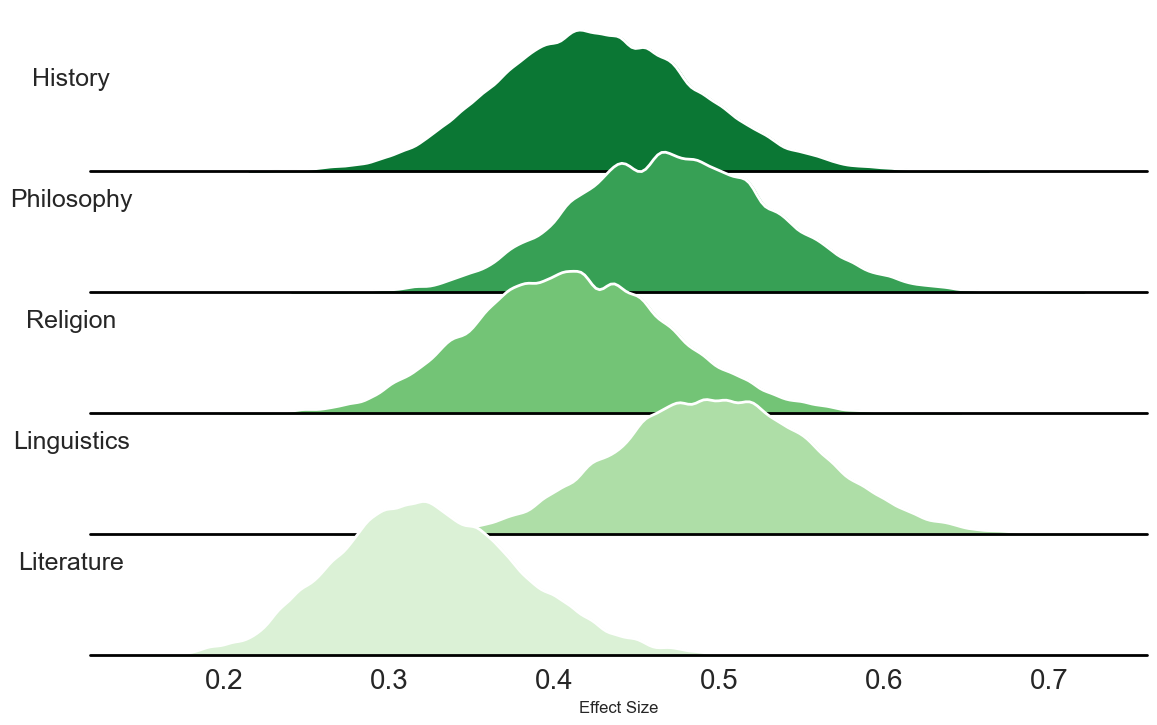

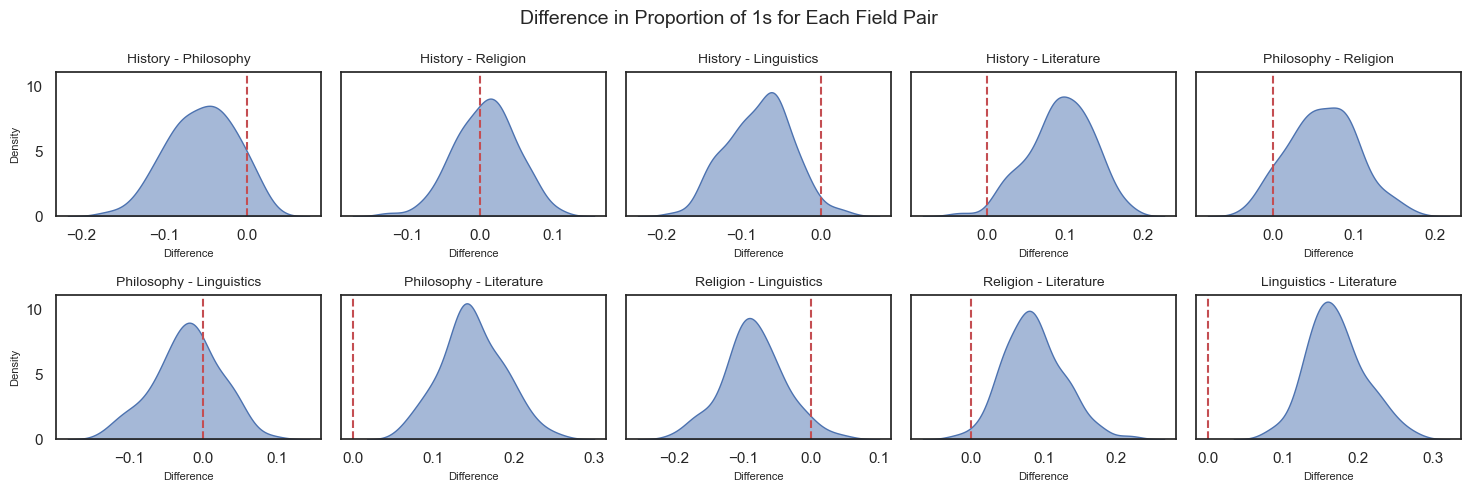

In [30]:
# plot the individual comparisons between fields
field_effect_sizes = {}
fig, axs = plt.subplots(2,5,figsize = (15,5), sharey=True)

for ax,i in zip(axs.flat, combinations(range(5),2)):
    
    # get the proportions of 1s in each of the ppc samples for each pair of fields
    field_a = trial_means[:,i[0]]
    field_b = trial_means[:,i[1]]
    
    # subtract the smaller from the larger
    
    
    dif = field_a - field_b

        
    # store and plot
    
    field_effect_sizes[f'dif_{i}'] = dif
    sns.kdeplot(dif, ax=ax, fill=True, alpha=0.5)

    ax.set_title(f'{fields_order[i[0]]} - {fields_order[i[1]]}', fontsize=10)
    ax.axvline(0, color='r', linestyle='--')  # Use a dashed line for visual clarity
    ax.set_xlabel('Difference', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)

plt.suptitle('Difference in Proportion of 1s for Each Field Pair', fontsize=14)
fig.tight_layout()
plt.show()

# QUESTION 3: Are raters chauvinistic?

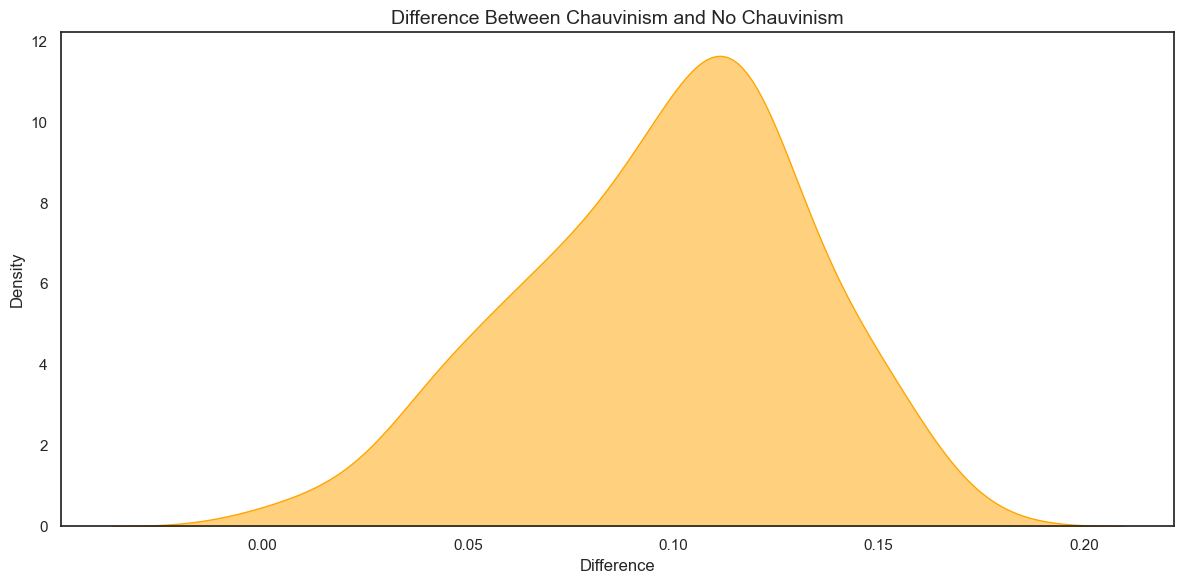

In [31]:

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(style="white")

text = ['Chauvinism', 'No Chauvinism']
chauv_mean = [trials_chauv[i].mean() for i in range(len(trials_chauv))]
nochauv_mean = [trials_nochauv[i].mean() for i in range(len(trials_nochauv))]


difference = np.array(chauv_mean) - np.array(nochauv_mean)
f2 = sns.kdeplot(difference, ax=ax, color='orange', fill=True, alpha=0.5)
ax.set_title('Difference Between Chauvinism and No Chauvinism', fontsize=14)
ax.set_xlabel('Difference', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

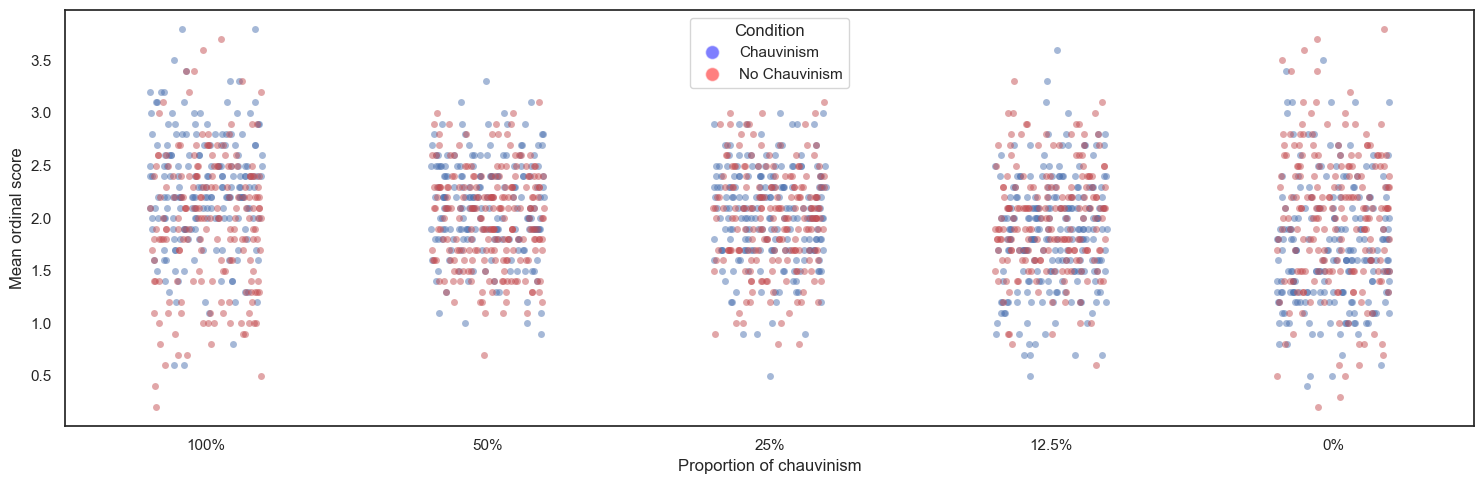

In [32]:
# plot the effect on ranking of switching on and off chauvinism

# Calculate counts of each score
scores = np.arange(5)  # Scores from 0 to 4

chauv_counts = np.concatenate([ranking_chauv[i] for i in range(len(ranking_chauv))])
chauv_counts = chauv_counts.mean(axis = (1))

nochauv_counts = np.concatenate([ranking_nochauv[i] for i in range(len(ranking_nochauv))])
nochauv_counts = nochauv_counts.mean(axis = (1))


fig, ax = plt.subplots(figsize=(15, 5), sharey=True, sharex=True)

dfx = pd.DataFrame(chauv_counts, columns = [f'{i}%' for i in ['100','50','25','12.5','0']]).stack().reset_index()
dfx['level_1'] = pd.Categorical(dfx['level_1'], categories = ['100%','50%','25%','12.5%','0%'], ordered=True)
sns.stripplot(dfx.sample(n = 1000), x = 'level_1', y = 0, jitter = 0.2,alpha = 0.5, ax=ax)
ax.set_ylabel('Mean ordinal score')
ax.set_xlabel('Proportion of chauvinism')
dfx = pd.DataFrame(nochauv_counts, columns = [f'{i}%' for i in ['100','50','25','12.5','0']]).stack().reset_index()
dfx['level_1'] = pd.Categorical(dfx['level_1'], categories = ['100%','50%','25%','12.5%','0%'], ordered=True)

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Chauvinism', 
           markerfacecolor='blue', markersize=10, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='No Chauvinism', 
           markerfacecolor='red', markersize=10, alpha=0.5)
]

# Add legend to the plot with the custom handles
ax.legend(handles=legend_elements, title='Condition')
sns.stripplot(dfx.sample(n = 1000).sort_values(by='level_1'), x = 'level_1',y = 0, color = 'r',jitter = 0.2,alpha = 0.5, ax=ax)


plt.tight_layout()
plt.show()

# QUESTION 4: Aggregate judgement of societal relevance

Note: there is a substantial difference between group 1 (0.32) and group 2 and main (around 0.4). According to the model, this is due to the raters in group 1 being exceptionally strict. If you do posterior predictive sampling with strictness sampled from the posteriors of those of group2, the model without chauvinism is centered around 0.32.

In [12]:
chauv_results.keys()

dict_keys(['chauv_trials', 'trials_chauv', 'trials_nochauv'])

In [13]:
chauv_props = np.array(chauv_results['trials_chauv']).mean(axis = (1,2,3))
nochauv_props = np.array(chauv_results['trials_nochauv']).mean(axis = (1,2,3))


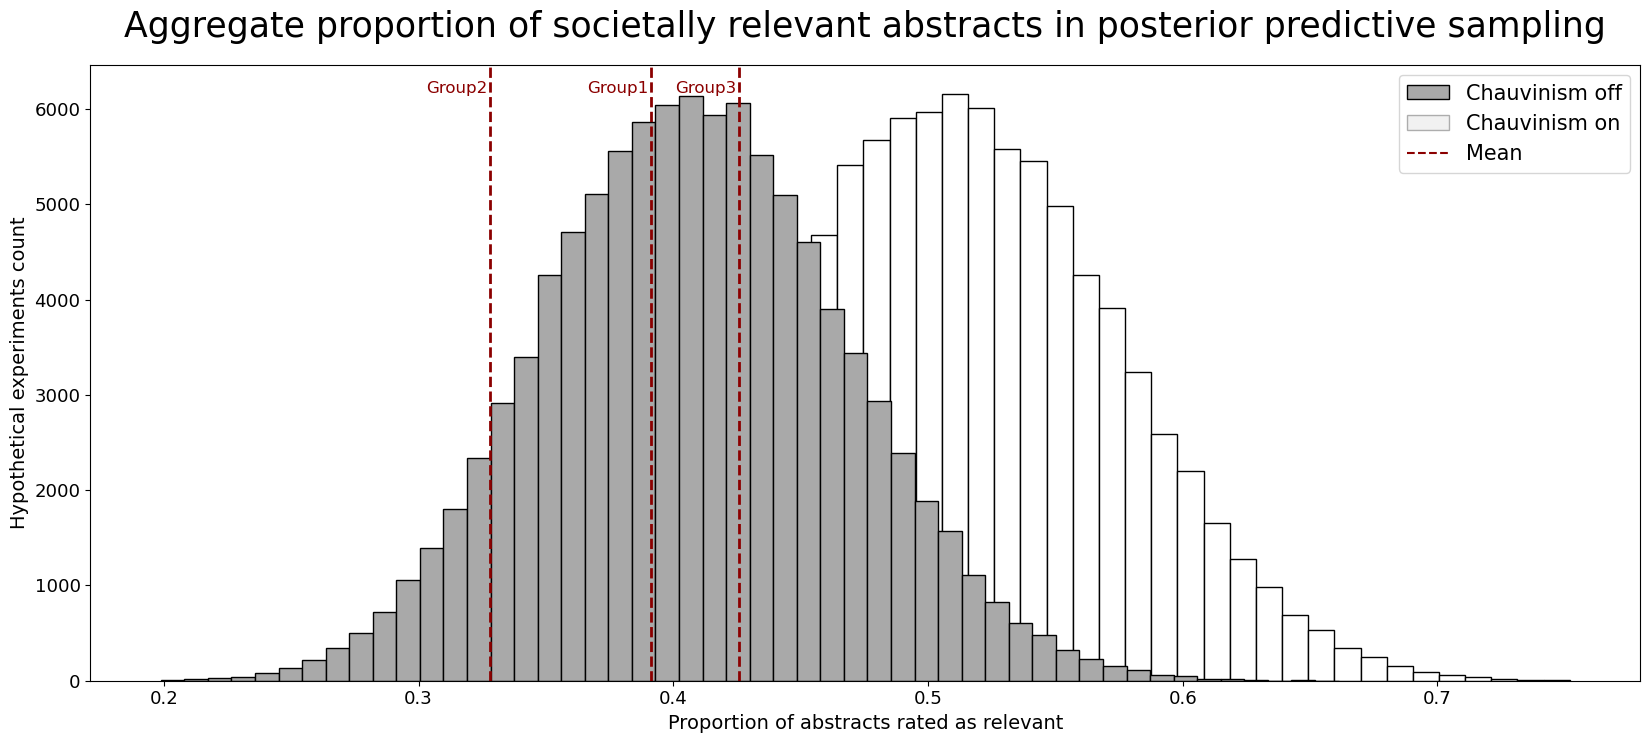

In [26]:
# we do N number of trials, each time with different reviewers, and record what proportion of 1s we get.
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize = (20,8))
hist2 = sns.histplot(chauv_props, bins = 50,color = 'white', edgecolor = 'black',alpha = 1,ax=ax)

hist1 = sns.histplot(nochauv_props, bins = 50,color = 'darkgrey',alpha = 1, edgecolor = 'black',ax=ax),





# ax.set_xlim([0.3,0.65])
# Annotate the line

for j,i in enumerate(['group1', 'group2','main']):
    mean = df.loc[df.group == i]['binary'].mean()
    ax.axvline(mean, color = 'darkred', lw = 2, ls = '--')
    ax.annotate(f"Group{j+1}", xy=(mean, ax.get_ylim()[1]), xytext=(mean - 0.025, ax.get_ylim()[1] - 300),ha='left', fontsize = 12, color = 'darkred')



# Manually create legend patches
legend_elements = [Patch(facecolor='darkgrey', edgecolor='black', label='Chauvinism off'),
                   Patch(facecolor='lightgrey', edgecolor='black', label='Chauvinism on', alpha = 0.3),
                  Line2D([0], [0], color='darkred', label='Mean', alpha=1, linestyle='--')]

# Set the legend with the custom patches
ax.legend(handles=legend_elements, facecolor='white', fontsize = 15)
ax.set_title('Aggregate proportion of societally relevant abstracts in posterior predictive sampling', fontsize = 25, pad = 20)
ax.set_ylabel('Hypothetical experiments count', fontsize = 14)
ax.set_xlabel('Proportion of abstracts rated as relevant', fontsize = 14)
fig.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\overall_estimate.png', dpi=300, bbox_inches='tight')
ax.tick_params(axis='x', labelsize=13)  # Change font size of x-axis tick labels
ax.tick_params(axis='y', labelsize=13)  # Change font size of x-axis tick labels









plt.show()

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Define font size variables
title_fontsize = 27
label_fontsize = 20
annotation_fontsize = 13
legend_fontsize = 15
tick_fontsize = 15
# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the histograms
hist2 = sns.histplot(chauv_props, bins=50, color='white', edgecolor='black', alpha=1, ax=ax)
hist1 = sns.histplot(nochauv_props, bins=50, color='darkgrey', alpha=1, edgecolor='black', ax=ax)

# Annotate the lines for different groups
for j, i in enumerate(['group1', 'group2', 'main']):
    mean = df.loc[df.group == i]['binary'].mean()
    ax.axvline(mean, color='darkred', lw=2, ls='--')
    ax.annotate(f"Group {j+1}", xy=(mean, ax.get_ylim()[1]), xytext=(mean - 0.033, ax.get_ylim()[1] - 50),
                ha='left', fontsize=annotation_fontsize, color='darkred')

# Manually create legend patches
legend_elements = [
    Patch(facecolor='darkgrey', edgecolor='black', label='Chauvinism off'),
    Patch(facecolor='lightgrey', edgecolor='black', label='Chauvinism on', alpha=0.3),
    Line2D([0], [0], color='darkred', label='Mean', alpha=1, linestyle='--')
]

# Set the legend with the custom patches
ax.legend(handles=legend_elements, facecolor='white', fontsize=legend_fontsize)

# Set title and labels with the defined font sizes
ax.set_title('Aggregate proportion of societally relevant papers in posterior predictive sampling', fontsize=title_fontsize, pad=20)
ax.set_ylabel('Hypothetical experiments count', fontsize=label_fontsize)
ax.set_xlabel('Proportion of documents rated as relevant', fontsize=label_fontsize)
# Save the figure
fig.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\overall_estimate.png', dpi=300, bbox_inches='tight')
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Show the plot
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols = 2)
az.plot_posterior(chauv_props, ax=ax[0])
ax[0].set_title('With chauvinism')

az.plot_posterior(nochauv_props, ax=ax[1])
ax[1].set_title('Without chauvinism')

# ADDITIONAL QUESTION 5: Differences between content codes

NameError: name 'content_params2' is not defined

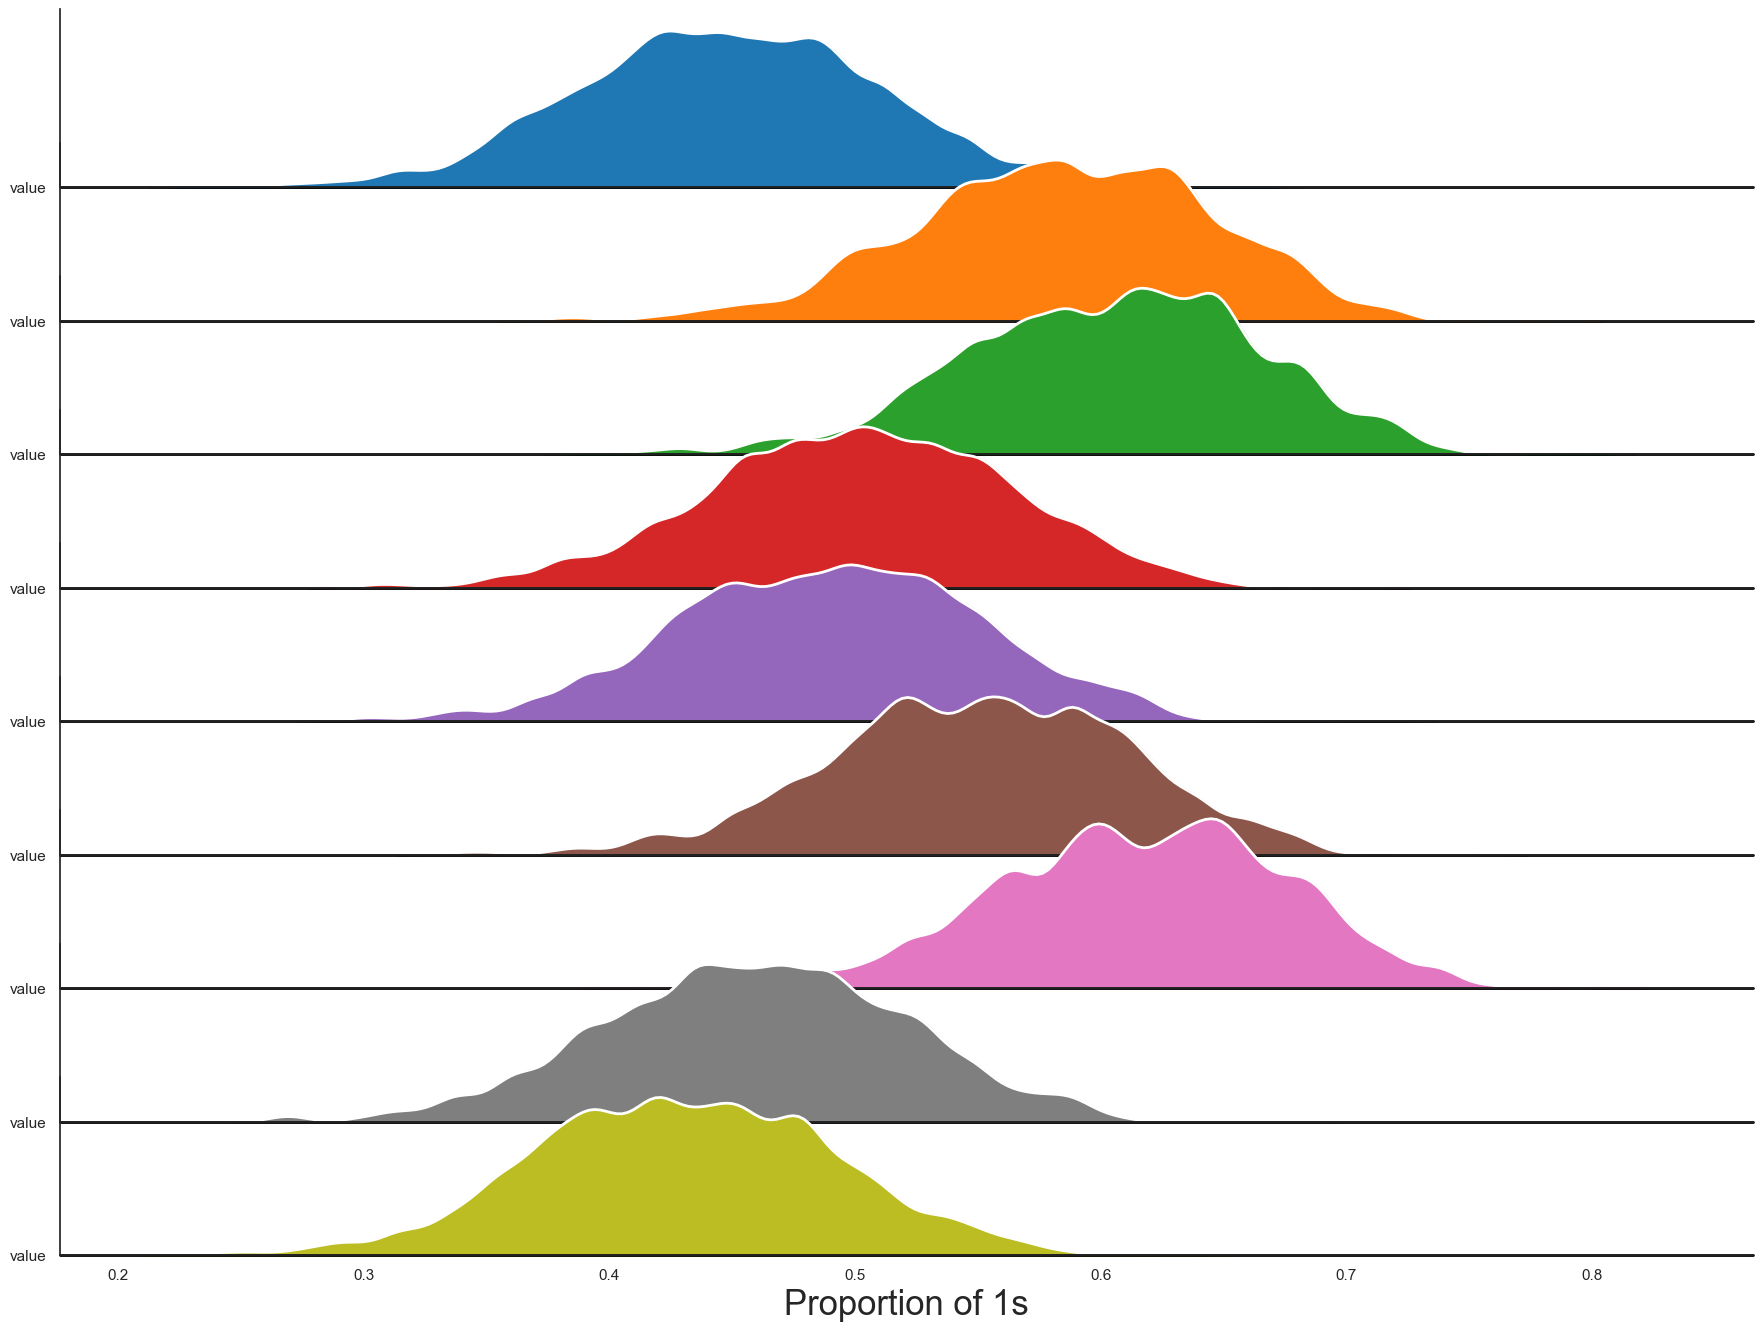

In [345]:
content_params = content_trials.keys()

# Ignore the specific UserWarnings related to tight_layout
warnings.filterwarnings('ignore', category=UserWarning)
# Convert dictionary to a long-form DataFrame for seaborn
dfx = pd.DataFrame([np.array(content_trials[i]).mean(axis = (1,2,3)) for i in content_params2 ], index = content_params2 ).T.stack().reset_index()
dfx.columns = ['index','Code','value']

# Create the ridge plot
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data for the ridge plot
g = sns.FacetGrid(dfx, row="Code", hue="Code", aspect=12, height=1.5, palette="tab10")

# Map the density plots to each facet
g.map(sns.kdeplot, "value", clip_on=False, shade=True, alpha=1, lw=1.5, bw_adjust=0.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Define a function to add a line for each level
def add_line(x, **kwargs):
    plt.axhline(y=x.name, color='black', lw=2, clip_on=False)

# Apply the function to each facet
g.map(add_line, "value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_xlabels("Proportion of 1s", fontsize = 25)
g.set_ylabels('')
ytick_positions = [0, 1, 2,3,4,5,6,7,8]
for ax, field in zip(g.axes.flat,content_params2 ):
    ax.set_yticks([7])  # Each subplot has a single y-tick at position 0
    ax.set_ylabel(field, fontsize = 25, rotation = 0)
    ax.tick_params(axis='x', labelsize=20)

g.despine(bottom=True, left=True)
plt.suptitle("Proportions of 1s in posterior predictive sampling from different content codes", fontsize = 25)

# Show the plot
plt.show()

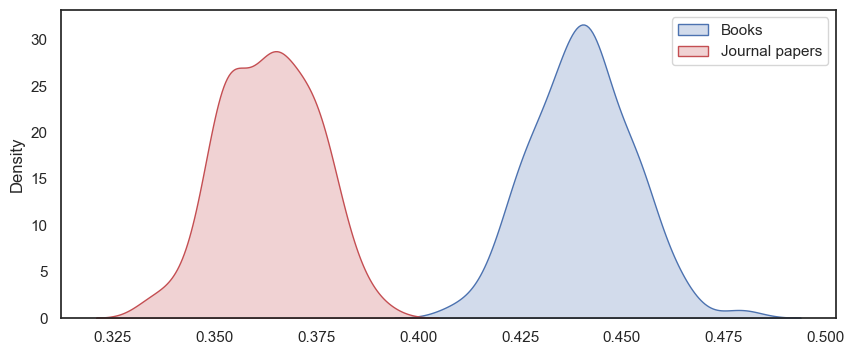

In [58]:
# doctype figure
sns.set(style="white")

fig, ax = plt.subplots(figsize = (10,4))

sns.kdeplot(dfx.loc[dfx.Code == 'doctype']['value'].values, fill = True, ax=ax)
sns.kdeplot(dfx.loc[dfx.Code == 'No code']['value'].values, color = 'r', fill=True, ax=ax)
ax.legend(['Books','Journal papers'])

<Axes: ylabel='Density'>

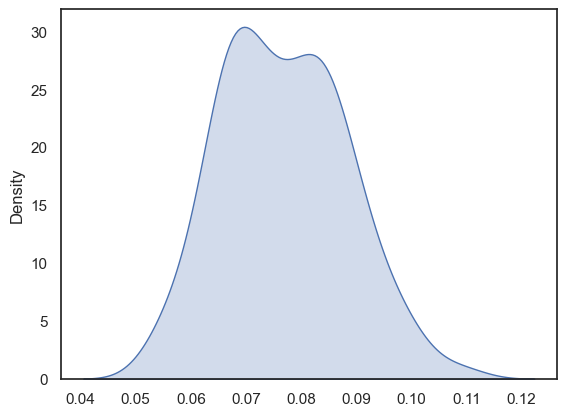

In [60]:
sns.kdeplot(dfx.loc[dfx.Code == 'doctype']['value'].values - dfx.loc[dfx.Code == 'No code']['value'].values, fill = True)

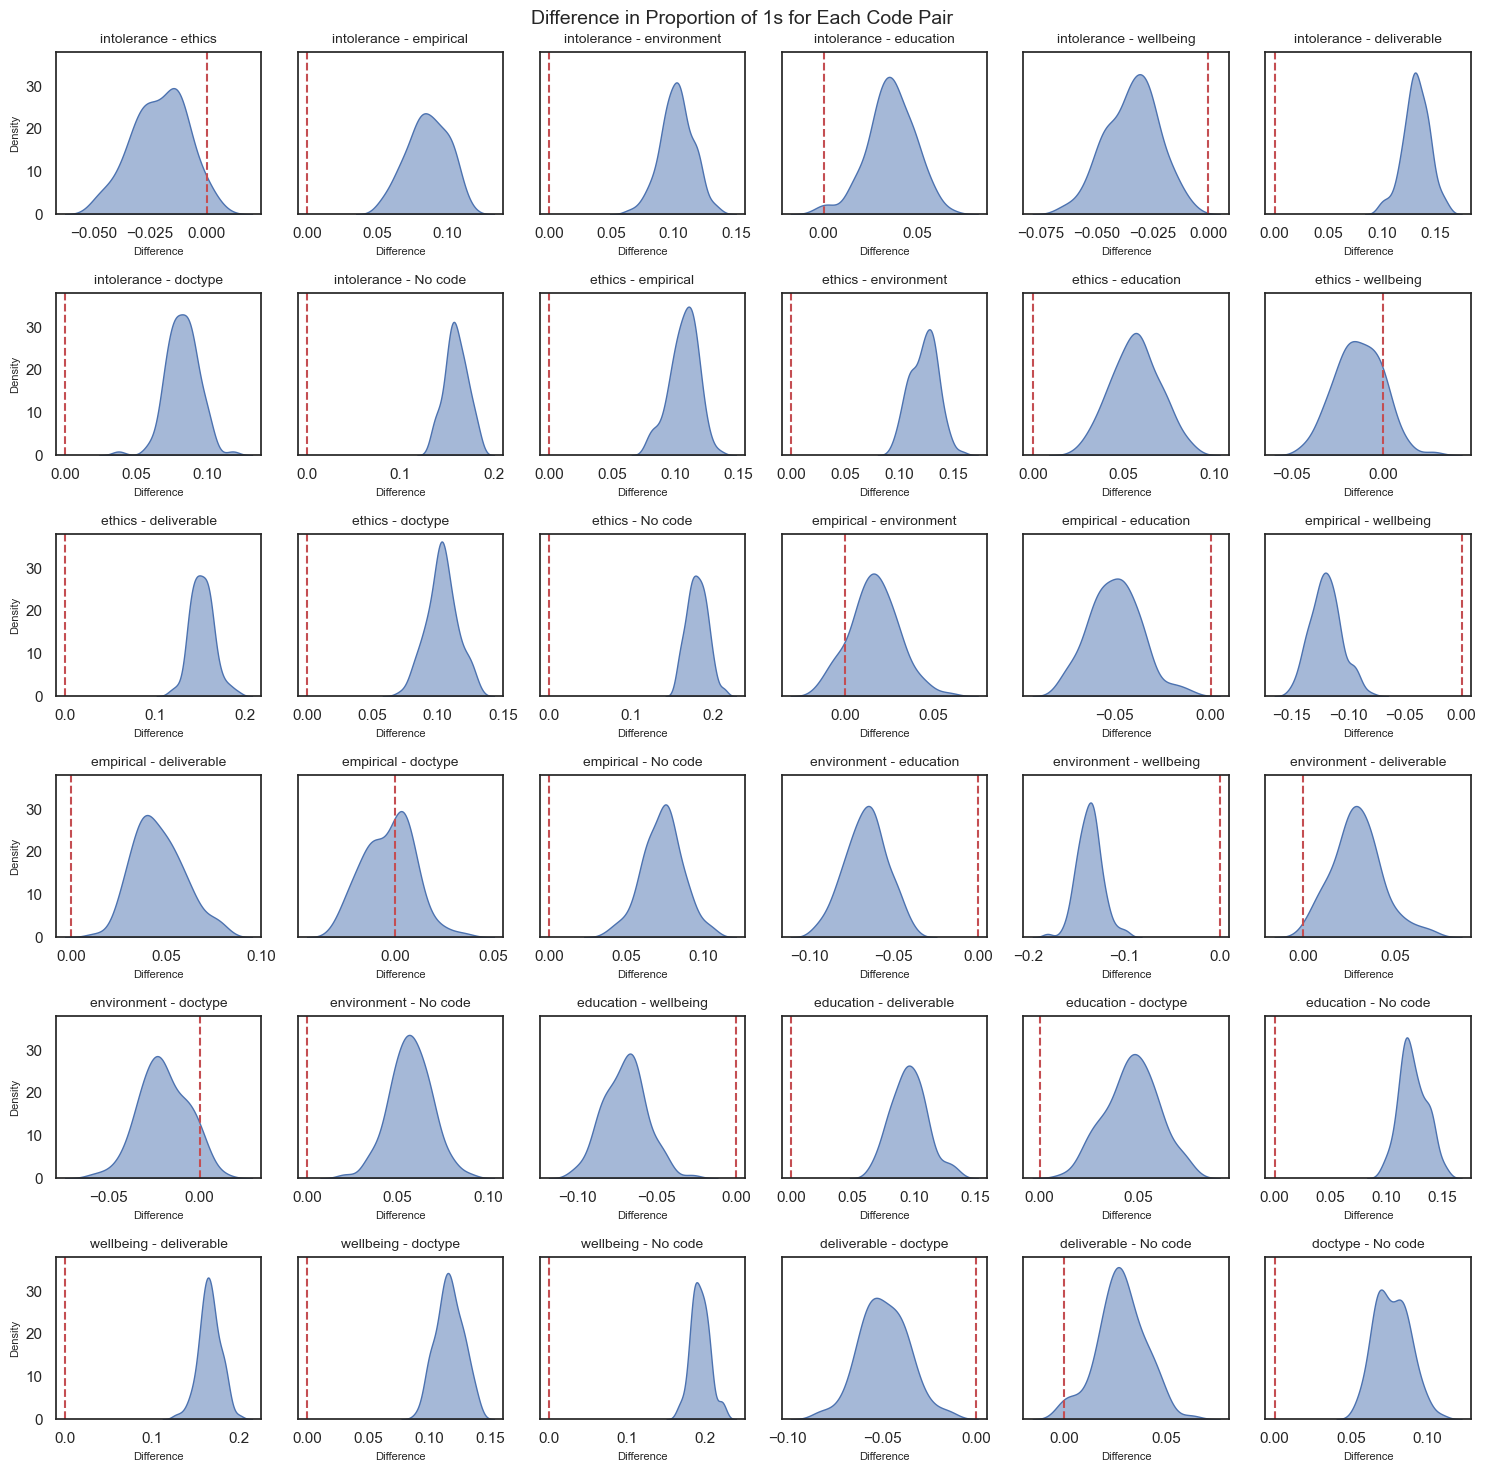

In [36]:
# plot the individual comparisons between fields
fig, axs = plt.subplots(6,6,figsize = (15,15), sharey=True)
content_effect_sizes = {}



for ax,i in zip(axs.flat, combinations(range(len(content_params2)),2)):
    
    # get the proportions of 1s in each of the ppc samples for each pair of fields
    code_a = np.array(content_trials[content_params2[i[0]]]).mean(axis = (1,2,3))
    code_b = np.array(content_trials[content_params2[i[1]]]).mean(axis = (1,2,3))
    
    # subtract the smaller from the larger
    
    
    dif = code_a - code_b

        
    # store and plot
    
    content_effect_sizes[f'dif_{i}'] = dif
    sns.kdeplot(dif, ax=ax, fill=True, alpha=0.5)

    ax.set_title(f'{content_params2[i[0]]} - {content_params2[i[1]]}', fontsize=10)
    ax.axvline(0, color='r', linestyle='--')  # Use a dashed line for visual clarity
    ax.set_xlabel('Difference', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)

plt.suptitle('Difference in Proportion of 1s for Each Code Pair', fontsize=14)
fig.tight_layout()
plt.show()

# Additional question 6: Comparison roles field/content and other paper specific features

We hypothesize that the field and content codes strongly determine the paper_value. Whatever isn't captured by those, is captured by individual paper_intercepts. Here we look at how much of the variation is captured by each of these.

In [37]:
# load the trace with the hyperprior for paper_intercepts

trace_chauvinism_thurstonian_all_varpaper = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_chauvinism_thurstonian_all_varpaper.nc")

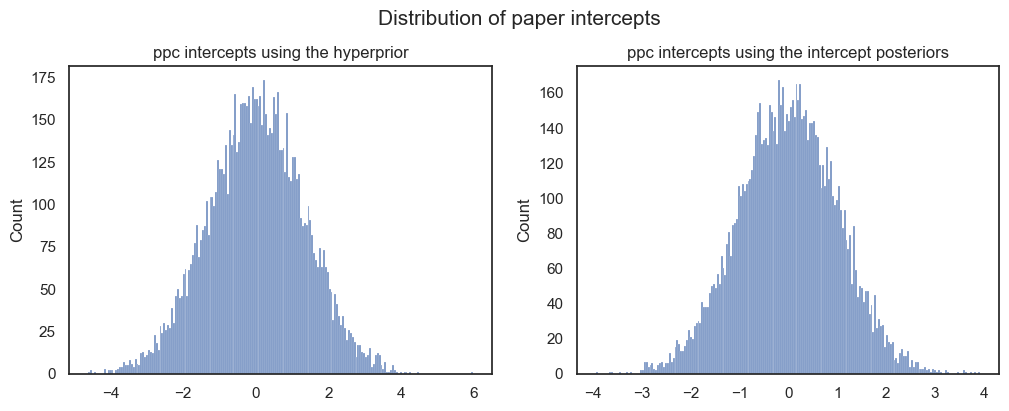

In [38]:
# expected distribution of paper_intercepts
# note, this is variation between papers not counting the role of the content codes or the field


# using the hyperprior
sds = np.random.choice(np.ravel(trace_chauvinism_thurstonian_all_varpaper.posterior['paper_var'].values), 10000, replace = True)
ppc_paper_intercepts = np.random.normal(0,sds)
plt.show()

# using the paper_intercepts themselves
# I use the content model to make comparison with field easier. The graph looks the same for the chauvinism and field models.
intercepts = np.ravel(trace_content_thurstonian_all.posterior['paper_intercepts'].values)
ppc_paper_intercepts2 = np.random.choice(intercepts, 10000, replace = True)

fig, ax = plt.subplots(ncols = 2, figsize = (12,4))

sns.histplot(ppc_paper_intercepts, bins = 200, ax=ax[0])
ax[0].set_title('ppc intercepts using the hyperprior')
sns.histplot(ppc_paper_intercepts2, bins = 200, ax=ax[1])
ax[1].set_title('ppc intercepts using the intercept posteriors')

plt.suptitle('Distribution of paper intercepts', fontsize = 15, y = 1.02)

plt.show()

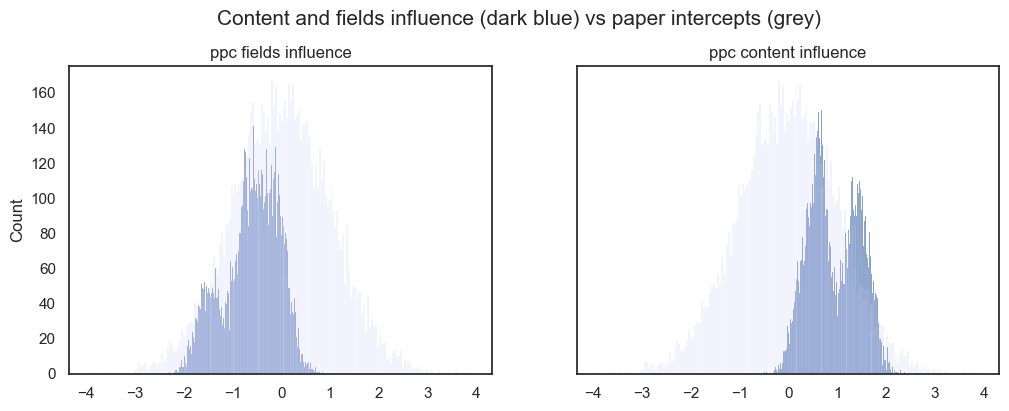

In [39]:
# now field and content

fields = np.ravel(trace_field_thurstonian_all.posterior['fields'].values)
ppc_fields = np.random.choice(fields, 10000, replace = True)

contents = np.ravel(trace_content_thurstonian_all.posterior['content'].values)
ppc_content = np.random.choice(contents, 10000, replace = True)

fig, ax = plt.subplots(ncols = 2, figsize = (12,4), sharex = True, sharey = True)

sns.histplot(ppc_fields, bins = 200, ax=ax[0])
ax[0].set_title('ppc fields influence')
sns.histplot(ppc_content, bins = 200, ax=ax[1])
ax[1].set_title('ppc content influence')

for i in range(2):
    sns.histplot(ppc_paper_intercepts2, bins = 200, color = 'blue', alpha = 0.05, ax = ax[i])

plt.suptitle('Content and fields influence (dark blue) vs paper intercepts (grey)', fontsize = 15, y = 1.02)

plt.show()

# Additional question 7: How many of the top 20% of our papers would have remained in that top with other reviewers?

In [40]:
# we need the relevant model for that as well, in this case that's the chauvinism model

K = 5
J_hum = 11
J_non_hum = 11

mData = prep_data_thurston(df, 'main')
g1Data = prep_data_thurston(df, 'group1')
g2Data = prep_data_thurston(df, 'group2')



mJ = len(df.loc[df.group == 'main']['rater'].unique())
g1J = len(df.loc[df.group == 'group1']['rater'].unique())
g2J = len(df.loc[df.group == 'group2']['rater'].unique())

mB = len(df.loc[df.group == 'main']['block'].unique())
g1B = len(df.loc[df.group == 'group1']['block'].unique())
g2B = len(df.loc[df.group == 'group1']['block'].unique())


with pm.Model() as chauvinism_thurstonian_all:

    # data

    rater_field = pm.Normal('rater_field',0,1, shape = K+1)

    fields_mean = pm.Normal('fields_mean', 0, 1)
    fields_sd = pm.Uniform('fields_sd', 0.01, 2)
    
    fields = pm.Normal('fields',0, fields_sd,shape = (K))

    # include the below if you want a hyperprior for the intercept sd
    # paper_var = pm.Uniform('paper_var',0.01,2)

    paper_intercepts = pm.Normal('paper_intercepts',0,1, shape = (mB + g1B + g2B)*K) # replace 1 by paper_var if you want to include the hyperprior for the sd

    # split the intercepts by group, and put them in the right shape by block
    m_intercepts = paper_intercepts[:mB*K].reshape((mB, K))
    g1_intercepts = paper_intercepts[mB*K:(mB*K) + (g1B*K)].reshape((g1B, K))
    g2_intercepts = paper_intercepts[(mB*K) + (g1B*K):].reshape((g2B, K))

    ## Non-centered parameterization for chauvinism
    chauv_mean = pm.Normal('chauv_mean', 0, 1)
    chauv_sd = pm.Uniform('chauv_sd', 0.01, 2)

    # need just zeros for the non-hum, as they cannot be chauvinistic
    c_offset_nonhum = pt.zeros((1, J_non_hum, 1))
    mchauvinism_offset = pm.Normal('mchauvinism_offset', 0, 1, shape=(1, J_hum, 1))
    chauvinism_hum = pm.Deterministic('chauvinism_hum', chauv_mean + chauv_sd * mchauvinism_offset)
    mchauvinism = pt.concatenate([chauvinism_hum, c_offset_nonhum], axis = 1)

    g1chauvinism_offset = pm.Normal('g1chauvinism_offset', 0, 1, shape=(1, g1J, 1))
    g1chauvinism = pm.Deterministic('g1chauvinism', chauv_mean + chauv_sd * g1chauvinism_offset)

    g2chauvinism_offset = pm.Normal('g2chauvinism_offset', 0, 1, shape=(1, g2J, 1))
    g2chauvinism = pm.Deterministic('g2chauvinism', chauv_mean + chauv_sd * g2chauvinism_offset)

    
    
    mpaper_values = pm.Deterministic('mpaper_values', m_intercepts + fields[mData['fields_presence']])
    g1paper_values = pm.Deterministic('g1paper_values', g1_intercepts + fields[g1Data['fields_presence']])
    g2paper_values = pm.Deterministic('g2paper_values', g2_intercepts + fields[g2Data['fields_presence']])




    mmu = pm.Deterministic('mmu', pt.tile(mpaper_values[:,pt.newaxis,:],(1,mJ,1))+ rater_field[mData['rater_fields']] + (mData['chauv_array'] * mchauvinism))
    g1mu = pm.Deterministic('g1mu', pt.tile(g1paper_values[:,pt.newaxis,:],(1,g1J,1))+rater_field[g1Data['rater_fields']] + (g1Data['chauv_array'] * g1chauvinism))
    g2mu = pm.Deterministic('g2mu', pt.tile(g2paper_values[:,pt.newaxis,:],(1,g2J,1))+ rater_field[g2Data['rater_fields']] + (g2Data['chauv_array'] * g2chauvinism))


    mreordered_mu = pm.Deterministic('mreordered_mu', pt.take_along_axis(mmu, mData['rank_data_argsort'], axis = -1))
    g1reordered_mu = pm.Deterministic('g1reordered_mu', pt.take_along_axis(g1mu, g1Data['rank_data_argsort'], axis = -1))
    g2reordered_mu = pm.Deterministic('g2reordered_mu', pt.take_along_axis(g2mu, g2Data['rank_data_argsort'], axis = -1))

    
    sigma = pm.Uniform('sigma',0.01,2)
    
    mlatent = pm.Normal('mlatent',
                       mu=mreordered_mu,
                       sigma=sigma, 
                       transform=Ordered(), 
                       shape=(mB,mJ,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (mB, 1))[:, np.newaxis, :], (1, mJ, 1))) 

    g1latent = pm.Normal('g1latent',
                       mu=g1reordered_mu,
                       sigma=sigma, 
                       transform=Ordered(), 
                       shape=(g1B,g1J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (g1B, 1))[:, np.newaxis, :], (1, g1J, 1)))
    
    g2latent = pm.Normal('g2latent',
                       mu=g2reordered_mu,
                       sigma=sigma, 
                       transform=Ordered(), 
                       shape=(g2B,g2J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (g2B, 1))[:, np.newaxis, :], (1, g2J, 1)))

    mlatent_reshaped = pt.take_along_axis(mlatent, mData['rank_data'], axis = -1)
    g1latent_reshaped = pt.take_along_axis(g1latent, g1Data['rank_data'], axis = -1)
    g2latent_reshaped = pt.take_along_axis(g2latent, g2Data['rank_data'], axis = -1)


    
    # Strictness
    strictness_sd = pm.Uniform('strictness_sd', 0.01, 2)
    
    strictness_offset1 = pm.Normal('strictness_offset1', 0, 1,  shape=(1, mJ, 1))
    strictness_offset2 = pm.Normal('strictness_offset2', 0, 1, shape=(1, g1J, 1))
    strictness_offset3 = pm.Normal('strictness_offset3', 0, 1,  shape=(1, g2J, 1))
    
    mstrictness = pm.Deterministic('mstrictness', strictness_offset1 * strictness_sd)
    g1strictness = pm.Deterministic('g1strictness', strictness_offset2 * strictness_sd)
    g2strictness = pm.Deterministic('g2strictness', strictness_offset3 * strictness_sd)


    mbinary = pm.Bernoulli('mbinary',logit_p = mlatent_reshaped + mstrictness, observed = mData['binary_data'])
    g1binary = pm.Bernoulli('g1binary',logit_p = g1latent_reshaped + g1strictness, observed = g1Data['binary_data'])
    g2binary = pm.Bernoulli('g2binary',logit_p = g2latent_reshaped + g2strictness, observed = g2Data['binary_data'])

    pr9 = pm.sample_prior_predictive()

Sampling: [chauv_mean, chauv_sd, fields, fields_mean, fields_sd, g1binary, g1chauvinism_offset, g1latent, g2binary, g2chauvinism_offset, g2latent, mbinary, mchauvinism_offset, mlatent, paper_intercepts, rater_field, sigma, strictness_offset1, strictness_offset2, strictness_offset3, strictness_sd]


In [41]:
# now sample posterior predictive a couple of times, but each time set different raters


with chauvinism_thurstonian_all:
    # Sample new strictness and chauvinism offsets for new raters
    new_strictness_offset = pm.Normal('new_strictness_offset', 0, 1, shape=(1, mJ, 1))
    new_strictness = pm.Deterministic('new_strictness', new_strictness_offset * strictness_sd)
    
    new_mchauvinism_offset = pm.Normal('new_mchauvinism_offset', 0, 1, shape=(1, J_hum, 1))
    new_chauvinism_hum = pm.Deterministic('new_chauvinism_hum', chauv_mean + chauv_sd * new_mchauvinism_offset)
    new_mchauvinism = pt.concatenate([new_chauvinism_hum, c_offset_nonhum], axis=1)

    new_g1chauvinism_offset = pm.Normal('new_g1chauvinism_offset', 0, 1, shape=(1, g1J, 1))
    new_g1chauvinism = pm.Deterministic('new_g1chauvinism', chauv_mean + chauv_sd * new_g1chauvinism_offset)

    new_g2chauvinism_offset = pm.Normal('new_g2chauvinism_offset', 0, 1, shape=(1, g2J, 1))
    new_g2chauvinism = pm.Deterministic('new_g2chauvinism', chauv_mean + chauv_sd * new_g2chauvinism_offset)

    # Compute new mu values with new strictness and chauvinism offsets
    new_mmu = pm.Deterministic('new_mmu', pt.tile(mpaper_values[:, pt.newaxis, :], (1, mJ, 1)) + rater_field[mData['rater_fields']] + (mData['chauv_array'] * new_mchauvinism))
    new_g1mu = pm.Deterministic('new_g1mu', pt.tile(g1paper_values[:, pt.newaxis, :], (1, g1J, 1)) + rater_field[g1Data['rater_fields']] + (g1Data['chauv_array'] * new_g1chauvinism))
    new_g2mu = pm.Deterministic('new_g2mu', pt.tile(g2paper_values[:, pt.newaxis, :], (1, g2J, 1)) + rater_field[g2Data['rater_fields']] + (g2Data['chauv_array'] * new_g2chauvinism))

    new_mreordered_mu = pm.Deterministic('new_mreordered_mu', pt.take_along_axis(new_mmu, mData['rank_data_argsort'], axis=-1))
    new_g1reordered_mu = pm.Deterministic('new_g1reordered_mu', pt.take_along_axis(new_g1mu, g1Data['rank_data_argsort'], axis=-1))
    new_g2reordered_mu = pm.Deterministic('new_g2reordered_mu', pt.take_along_axis(new_g2mu, g2Data['rank_data_argsort'], axis=-1))

    new_mlatent = pm.Normal('new_mlatent',
                            mu=new_mreordered_mu,
                            sigma=sigma,
                            transform=Ordered(),
                            shape=(mB, mJ, K),
                            testval=np.tile(np.tile(np.arange(K), (mB, 1))[:, np.newaxis, :], (1, mJ, 1)))

    new_g1latent = pm.Normal('new_g1latent',
                             mu=new_g1reordered_mu,
                             sigma=sigma,
                             transform=Ordered(),
                             shape=(g1B, g1J, K),
                             testval=np.tile(np.tile(np.arange(K), (g1B, 1))[:, np.newaxis, :], (1, g1J, 1)))

    new_g2latent = pm.Normal('new_g2latent',
                             mu=new_g2reordered_mu,
                             sigma=sigma,
                             transform=Ordered(),
                             shape=(g2B, g2J, K),
                             testval=np.tile(np.tile(np.arange(K), (g2B, 1))[:, np.newaxis, :], (1, g2J, 1)))

    new_mlatent_reshaped = pt.take_along_axis(new_mlatent, mData['rank_data'], axis=-1)
    new_g1latent_reshaped = pt.take_along_axis(new_g1latent, g1Data['rank_data'], axis=-1)
    new_g2latent_reshaped = pt.take_along_axis(new_g2latent, g2Data['rank_data'], axis=-1)

    new_mbinary = pm.Bernoulli('new_mbinary', logit_p=new_mlatent_reshaped + new_strictness, observed=mData['binary_data'])
    new_g1binary = pm.Bernoulli('new_g1binary', logit_p=new_g1latent_reshaped + g1strictness, observed=g1Data['binary_data'])
    new_g2binary = pm.Bernoulli('new_g2binary', logit_p=new_g2latent_reshaped + g2strictness, observed=g2Data['binary_data'])

    new_posterior_predictive = pm.sample_posterior_predictive(trace_chauv_thurstonian_all, var_names=['new_mbinary', 'new_g1binary', 'new_g2binary'])


Sampling: [new_g1binary, new_g1chauvinism_offset, new_g1latent, new_g2binary, new_g2chauvinism_offset, new_g2latent, new_mbinary, new_mchauvinism_offset, new_mlatent, new_strictness_offset]


In [42]:
m_winners = pd.Series(np.ravel(mData['binary_data'].sum(axis = 1))).sort_values(ascending = False)[:31]
m_winners = list(m_winners.index)

g1_winners = pd.Series(np.ravel(g1Data['binary_data'].sum(axis = 1))).sort_values(ascending = False)[:69]
g1_winners = list(g1_winners.index)

g2_winners = pd.Series(np.ravel(g2Data['binary_data'].sum(axis = 1))).sort_values(ascending = False)[:77]
g2_winners = list(g2_winners.index)

def get_and_plot_winners(og_winners, data, prop):
    
    n_papers = data.shape[0] * 5
    n_winners = int(n_papers * prop)
    n_experiments = data.shape[-1]
    dct = {i:0 for i in range(n_papers)}
    for i in tqdm(range(n_experiments)):
        data_single = data[:,:,:,i]
        winners = pd.Series(np.ravel(data_single.sum(axis = 1))).sort_values(ascending = False)[:n_winners].index
        for j in winners:
            dct[j] += 1
            
    dct2 = {i:dct[i] for i in og_winners}

    fig, ax = plt.subplots(ncols = 2, figsize = (15,5))

    ax[0].bar(height = pd.Series(dct).sort_values().values / n_experiments, x = range(n_papers))
    ax[0].set_title(f'Distribution of how often the various papers were in the top {prop*100}%') 
    
    ax[1].bar(height = pd.Series(dct2).sort_values().values / n_experiments, x = range(len(pd.Series(dct2).values)))
    ax[1].set_title(f'How often the winners of our experiment were in the top {prop*100}')
    
    

100%|██████████| 8000/8000 [00:03<00:00, 2234.15it/s]


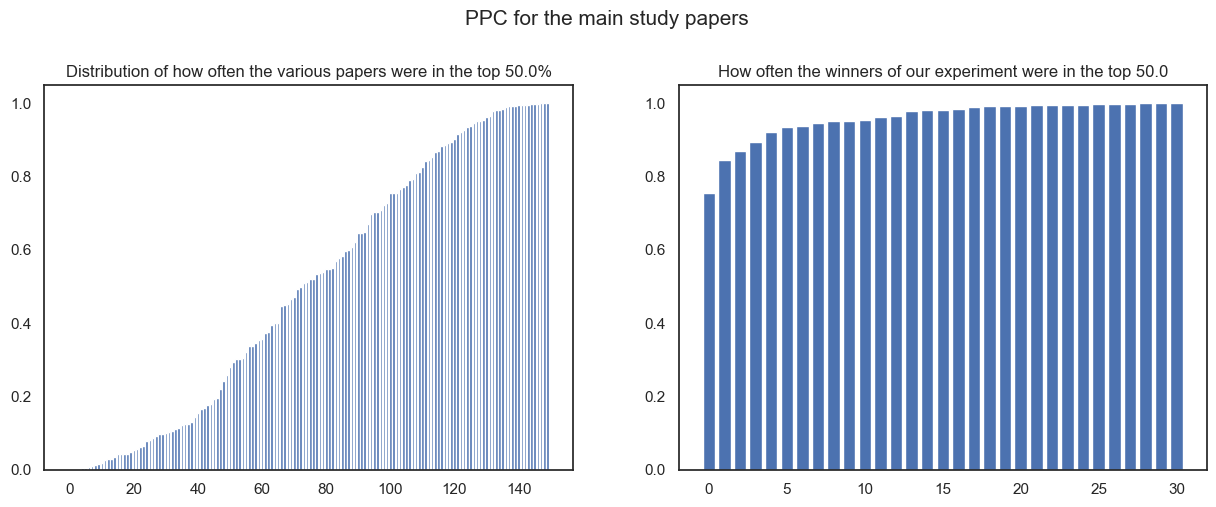

In [43]:
get_and_plot_winners(m_winners, az.extract(new_posterior_predictive.posterior_predictive["new_mbinary"])['new_mbinary'], 0.5)
plt.suptitle('PPC for the main study papers', fontsize = 15, y = 1.03)
plt.show()

100%|██████████| 8000/8000 [00:04<00:00, 1777.19it/s]


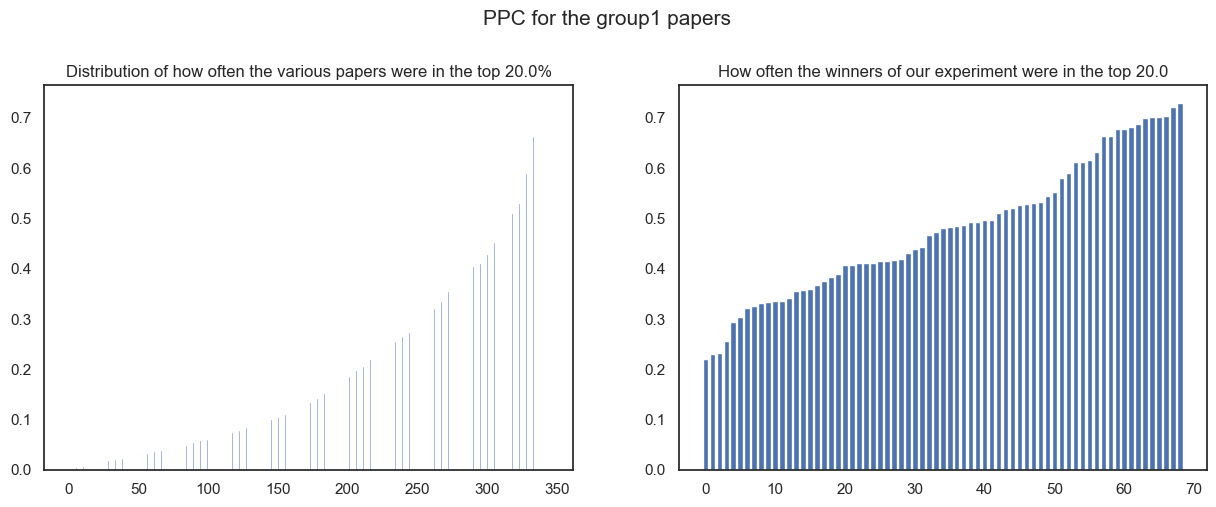

In [44]:
get_and_plot_winners(g1_winners, az.extract(new_posterior_predictive.posterior_predictive["new_g1binary"])['new_g1binary'], 0.2)
plt.suptitle('PPC for the group1 papers', fontsize = 15, y = 1.03)
plt.show()

100%|██████████| 8000/8000 [00:04<00:00, 1635.11it/s]


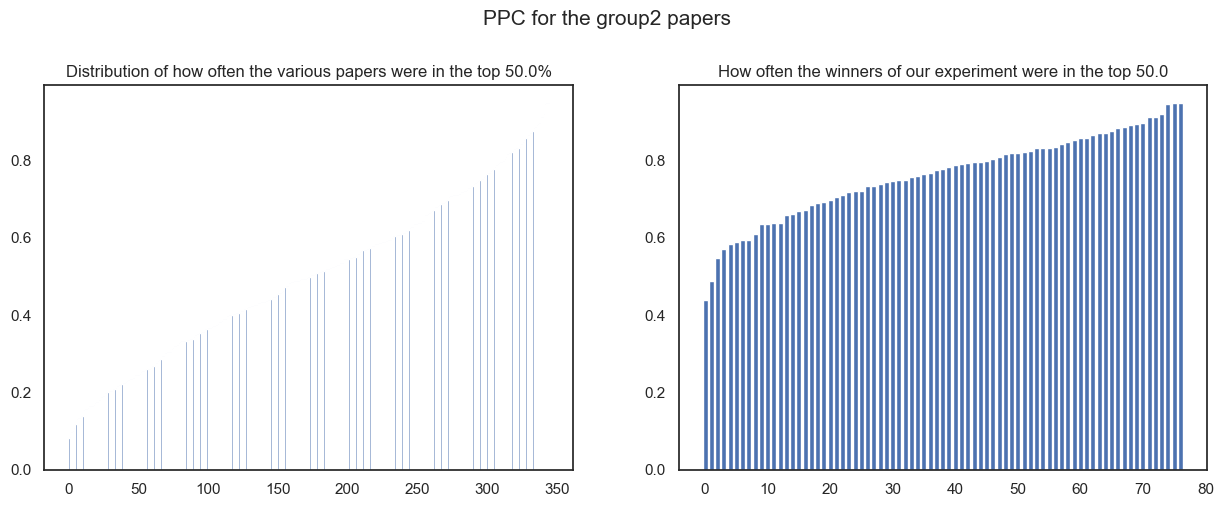

In [45]:
get_and_plot_winners(g2_winners, az.extract(new_posterior_predictive.posterior_predictive["new_g2binary"])['new_g2binary'], 0.5)
plt.suptitle('PPC for the group2 papers', fontsize = 15, y = 1.03)
plt.show()

In [46]:
# ppc samples with chauvinism set to zero

with chauvinism_thurstonian_all:
    # Set chauvinism to 0
    mchauvinism_zero = pt.zeros_like(mchauvinism)
    g1chauvinism_zero = pt.zeros_like(g1chauvinism)
    g2chauvinism_zero = pt.zeros_like(g2chauvinism)

    # Calculate new mu values with chauvinism set to 0
    mmu_zero = pm.Deterministic('mmu_zero', pt.tile(mpaper_values[:, pt.newaxis, :], (1, mJ, 1)) + rater_field[mData['rater_fields']] + (mData['chauv_array'] * mchauvinism_zero))
    g1mu_zero = pm.Deterministic('g1mu_zero', pt.tile(g1paper_values[:, pt.newaxis, :], (1, g1J, 1)) + rater_field[g1Data['rater_fields']] + (g1Data['chauv_array'] * g1chauvinism_zero))
    g2mu_zero = pm.Deterministic('g2mu_zero', pt.tile(g2paper_values[:, pt.newaxis, :], (1, g2J, 1)) + rater_field[g2Data['rater_fields']] + (g2Data['chauv_array'] * g2chauvinism_zero))

    mreordered_mu_zero = pm.Deterministic('mreordered_mu_zero', pt.take_along_axis(mmu_zero, mData['rank_data_argsort'], axis=-1))
    g1reordered_mu_zero = pm.Deterministic('g1reordered_mu_zero', pt.take_along_axis(g1mu_zero, g1Data['rank_data_argsort'], axis=-1))
    g2reordered_mu_zero = pm.Deterministic('g2reordered_mu_zero', pt.take_along_axis(g2mu_zero, g2Data['rank_data_argsort'], axis=-1))

    mlatent_zero = pm.Normal('mlatent_zero',
                             mu=mreordered_mu_zero,
                             sigma=sigma,
                             transform=Ordered(),
                             shape=(mB, mJ, K),
                             testval=np.tile(np.tile(np.arange(K), (mB, 1))[:, np.newaxis, :], (1, mJ, 1)))

    g1latent_zero = pm.Normal('g1latent_zero',
                              mu=g1reordered_mu_zero,
                              sigma=sigma,
                              transform=Ordered(),
                              shape=(g1B, g1J, K),
                              testval=np.tile(np.tile(np.arange(K), (g1B, 1))[:, np.newaxis, :], (1, g1J, 1)))

    g2latent_zero = pm.Normal('g2latent_zero',
                              mu=g2reordered_mu_zero,
                              sigma=sigma,
                              transform=Ordered(),
                              shape=(g2B, g2J, K),
                              testval=np.tile(np.tile(np.arange(K), (g2B, 1))[:, np.newaxis, :], (1, g2J, 1)))

    mlatent_reshaped_zero = pt.take_along_axis(mlatent_zero, mData['rank_data'], axis=-1)
    g1latent_reshaped_zero = pt.take_along_axis(g1latent_zero, g1Data['rank_data'], axis=-1)
    g2latent_reshaped_zero = pt.take_along_axis(g2latent_zero, g2Data['rank_data'], axis=-1)

    mbinary_zero = pm.Bernoulli('mbinary_zero', logit_p=mlatent_reshaped_zero + mstrictness)
    g1binary_zero = pm.Bernoulli('g1binary_zero', logit_p=g1latent_reshaped_zero + g1strictness)
    g2binary_zero = pm.Bernoulli('g2binary_zero', logit_p=g2latent_reshaped_zero + g2strictness)

    ppc_zero = pm.sample_posterior_predictive(trace_chauv_thurstonian_all, var_names=['mbinary_zero', 'g1binary_zero', 'g2binary_zero'])


Sampling: [g1binary_zero, g1latent_zero, g2binary_zero, g2latent_zero, mbinary_zero, mlatent_zero]


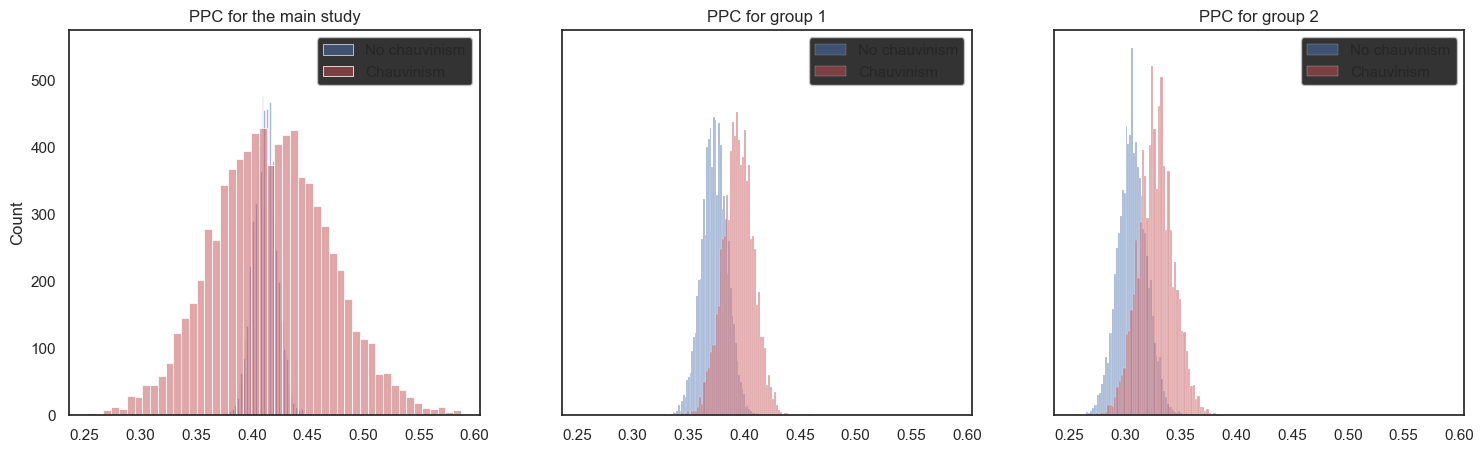

In [47]:
ppc_zero_m = az.extract(ppc_zero.posterior_predictive)['mbinary_zero'].mean(axis = (0,1,2)).values
ppc_zero_g1 = az.extract(ppc_zero.posterior_predictive)['g1binary_zero'].mean(axis = (0,1,2)).values
ppc_zero_g2 = az.extract(ppc_zero.posterior_predictive)['g2binary_zero'].mean(axis = (0,1,2)).values

ppc_m = az.extract(new_posterior_predictive.posterior_predictive)['new_mbinary'].mean(axis = (0,1,2)).values
ppc_g1 = az.extract(new_posterior_predictive.posterior_predictive)['new_g1binary'].mean(axis = (0,1,2)).values
ppc_g2 = az.extract(new_posterior_predictive.posterior_predictive)['new_g2binary'].mean(axis = (0,1,2)).values

fig, ax = plt.subplots(ncols = 3, figsize = (18,5), sharex = True, sharey = True)

sns.histplot(ppc_zero_m, color = 'b', ax=ax[0], alpha = 0.5)
sns.histplot(ppc_m, color = 'r', ax=ax[0], alpha = 0.5)
ax[0].legend(['No chauvinism','Chauvinism'])
ax[0].set_title("PPC for the main study")

sns.histplot(ppc_zero_g1, color = 'b', ax=ax[1], alpha = 0.5)
sns.histplot(ppc_g1, color = 'r', ax=ax[1], alpha = 0.5)
ax[1].legend(['No chauvinism','Chauvinism'])
ax[1].set_title("PPC for group 1")

sns.histplot(ppc_zero_g2, color = 'b', ax=ax[2], alpha = 0.5)
sns.histplot(ppc_g2, color = 'r', ax=ax[2], alpha = 0.5)
ax[2].legend(['No chauvinism','Chauvinism'])
ax[2].set_title("PPC for group 2")


plt.show()